In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from ncon import ncon
from scipy.linalg import svd, norm, qr

import BoseHubbard
import NTU
from Tools import truncate3
from time import time
import Ising
from IPython.display import clear_output
from matplotlib.pyplot import matshow
import CTMRG_better
import Corelations_test, Corelations

ifrandom = True
ifprint = True
env = {}
maxiter = 1000
precision = 1e-13
invprecision = 1e-10

In [2]:
def Corelation(env, PEPS, OL, OR, nmax):
    print("############################")
    t0 = time()
    # corelationsA, corelationsB = [np.trace(env['rhoA'] @ OL @ OR)], [np.trace(env['rhoB'] @ OL @ OR)]
    corelationsA, corelationsB = [], []

    A = PEPS['A']
    B = PEPS['B']
    AOL = A @ OL.T
    AOR = A @ OR.T
    BOL = B @ OL.T
    BOR = B @ OR.T
    E_E_A = env['E_E_A']
    E_E_B = env['E_E_B']
    E_W_A = env['E_W_A']
    E_W_B = env['E_W_B']
    E_S_A = env['E_S_A']
    E_S_B = env['E_S_B']
    E_N_A = env['E_N_A']
    E_N_B = env['E_N_B']
    C_NW_A = env['C_NW_A']
    C_SE_A = env['C_SE_A']
    C_NE_A = env['C_NE_A']
    C_SW_A = env['C_SW_A']
    C_NE_B = env['C_NE_B']
    C_SW_B = env['C_SW_B']
    C_NW_B = env['C_NW_B']
    C_SE_B = env['C_SE_B']

    def AddLayerLeft(L0, EdgeUp, X, Xc, EdgeDown):
        chi = EdgeUp.shape[0]
        D = X.shape[0]
        d = X.shape[-1]

        L1 = ncon([L0, EdgeUp], ([1, -3, -5, -6], [-1, 1, -2, -4]))

        L2 = ncon([L1.reshape(chi, D * D, D, D, chi), X.swapaxes(3, 2).swapaxes(2, 1).reshape(D * D, D, D, d)],
                  ([-1, 1, -5, -6, -7], [1, -2, -3, -4]))

        L3 = ncon([L2.reshape(chi, D, D, d * D * D, chi),
                   Xc.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
                       d * D * D, D, D)], ([-1, -2, -4, 1, -6], [1, -3, -5]))

        L4 = ncon([L3.reshape(chi, D, D, D * D * chi), EdgeDown.swapaxes(0, 1).reshape(chi, chi * D * D)],
                  ([-1, -2, -3, 1], [-4, 1]))

        return ncon([L0, EdgeUp, EdgeDown, X, Xc],
                    ([1, 2, 3, 9], [-1, 1, 5, 6], [9, -4, 7, 8], [5, -2, 7, 2, 4], [6, -3, 8, 3, 4]))

        return L4

    def AddLayerRight(R0, EdgeUp, X, Xc, EdgeDown):
        chi = EdgeUp.shape[0]
        D = X.shape[0]
        d = X.shape[-1]

        R1 = ncon([R0, EdgeUp], ([1, -3, -5, -6], [1, -1, -2, -4]))

        R2 = ncon([R1.reshape(chi, D * D, D, D, chi), X.reshape(D * D, D, D, d)],
                  ([-1, 1, -2, -3, -7], [1, -6, -5, -4]))

        R3 = ncon([R2.reshape(chi, D * D * d, D, D, chi), Xc.swapaxes(4, 3).swapaxes(3, 2).reshape(D * D * d, D, D)],
                  ([-1, 1, -2, -5, -6], [1, -4, -3]))

        R4 = ncon([R3.reshape(chi, D, D, D * D * chi), EdgeDown.reshape(chi, D * D * chi)], ([-1, -2, -3, 1], [-4, 1]))

        return ncon([R0, EdgeUp, EdgeDown, X, Xc],
                    ([1, 4, 5, 9], [1, -1, 2, 3], [-4, 9, 7, 8], [2, 4, 7, -2, 6], [3, 5, 8, -3, 6]))

        return R4

    def CreateLeft(Cup, Edge, Cdown):
        return ncon([Cup, Edge, Cdown], ([-1, 1], [1, 2, -2, -3], [2, -4]))

    def CreateRight(Cup, Edge, Cdown):
        return ncon([Cup, Edge, Cdown], ([1, -1], [2, 1, -2, -3], [-4, 2]))

    def FinishLeftRight(Left, Right):
        return ncon([Left, Right], ([1, 2, 3, 4], [1, 2, 3, 4]))
        return Left.flatten() @ Right.flatten()

    LeftOP_A = CreateLeft(C_NW_A, E_W_B, C_SW_A)
    LeftEM_A = LeftOP_A
    LeftOP_B = CreateLeft(C_NW_B, E_W_A, C_SW_B)
    LeftEM_B = LeftOP_B
    RightOP_A = CreateRight(C_NE_A, E_E_B, C_SE_A)
    RightEM_A = RightOP_A
    RightOP_B = CreateRight(C_NE_B, E_E_A, C_SE_B)
    RightEM_B = RightOP_B

    LeftOP_A = AddLayerLeft(LeftOP_A, E_N_B, A @ OL.T @ OR.T, A.conj(), E_S_B)
    LeftOP_B = AddLayerLeft(LeftOP_B, E_N_A, B @ OL.T @ OR.T, B.conj(), E_S_A)
    LeftEM_A = AddLayerLeft(LeftEM_A, E_N_B, A, A.conj(), E_S_B)
    LeftEM_B = AddLayerLeft(LeftEM_B, E_N_A, B, B.conj(), E_S_A)
    corelationsA.append(FinishLeftRight(LeftOP_A, RightOP_A) / FinishLeftRight(LeftEM_A, RightEM_A))
    corelationsB.append(FinishLeftRight(LeftOP_B, RightOP_B) / FinishLeftRight(LeftEM_B, RightEM_B))

    LeftOP_A = CreateLeft(C_NW_A, E_W_B, C_SW_A)
    LeftEM_A = LeftOP_A
    LeftOP_B = CreateLeft(C_NW_B, E_W_A, C_SW_B)
    LeftEM_B = LeftOP_B
    RightOP_A = CreateRight(C_NE_A, E_E_B, C_SE_A)
    RightEM_A = RightOP_A
    RightOP_B = CreateRight(C_NE_B, E_E_A, C_SE_B)
    RightEM_B = RightOP_B

    LeftOP_A = AddLayerLeft(LeftOP_A, E_N_B, A @ OL.T, A.conj(), E_S_B)
    LeftOP_B = AddLayerLeft(LeftOP_B, E_N_A, B @ OL.T, B.conj(), E_S_A)
    LeftEM_A = AddLayerLeft(LeftEM_A, E_N_B, A, A.conj(), E_S_B)
    LeftEM_B = AddLayerLeft(LeftEM_B, E_N_A, B, B.conj(), E_S_A)

    for iter in range(nmax):
        LeftOP_Aprim = AddLayerLeft(LeftOP_A, E_N_A, B @ OR.T, B.conj(), E_S_A)
        LeftOP_Bprim = AddLayerLeft(LeftOP_B, E_N_B, A @ OR.T, A.conj(), E_S_B)
        LeftOP_A = AddLayerLeft(LeftOP_A, E_N_A, B, B.conj(), E_S_A)
        LeftOP_B = AddLayerLeft(LeftOP_B, E_N_B, A, A.conj(), E_S_B)
        LeftEM_A = AddLayerLeft(LeftEM_A, E_N_A, B, B.conj(), E_S_A)
        LeftEM_B = AddLayerLeft(LeftEM_B, E_N_B, A, A.conj(), E_S_B)
        corelationsA.append(FinishLeftRight(LeftOP_Aprim, RightOP_B) / FinishLeftRight(LeftEM_A, RightEM_B))
        corelationsB.append(FinishLeftRight(LeftOP_Bprim, RightOP_A) / FinishLeftRight(LeftEM_B, RightEM_A))

        LeftOP_Aprim = AddLayerLeft(LeftOP_B, E_N_B, AOR, A.conj(), E_S_B)
        LeftOP_Bprim = AddLayerLeft(LeftOP_A, E_N_A, BOR, B.conj(), E_S_A)
        LeftOP_A = AddLayerLeft(LeftOP_B, E_N_B, A, A.conj(), E_S_B)
        LeftOP_B = AddLayerLeft(LeftOP_A, E_N_A, B, B.conj(), E_S_A)
        LeftEM_A = AddLayerLeft(LeftEM_B, E_N_B, A, A.conj(), E_S_B)
        LeftEM_B = AddLayerLeft(LeftEM_A, E_N_A, B, B.conj(), E_S_A)
        corelationsB.append(FinishLeftRight(LeftOP_Aprim, RightOP_A) / FinishLeftRight(LeftEM_A, RightEM_A))
        corelationsA.append(FinishLeftRight(LeftOP_Bprim, RightOP_B) / FinishLeftRight(LeftEM_B, RightEM_B))

    # LeftOP_Aprim = AddLayerLeft(LeftOP_A, E_N_A, BOR, B.conj(), E_S_A)
    # LeftOP_Bprim = AddLayerLeft(LeftOP_B, E_N_B, AOR, A.conj(), E_S_B)
    # corelationsA.append(FinishLeftRight(LeftOP_Aprim,RightOP_A)/FinishLeftRight(LeftEM_A,RightEM_A))
    # corelationsB.append(FinishLeftRight(LeftOP_Bprim,RightOP_B)/FinishLeftRight(LeftEM_B,RightEM_B))
    print("\t", 2 * nmax, "/", 2 * nmax)

    return {'corA': np.array(corelationsA), 'corB': np.array(corelationsB)}


In [8]:
D = 5
d = 3

ifrandom = False
if ifrandom:
    PEPS = {'A': np.zeros((D, D, D, D, d))}
    Dnec = 5
    PEPS['A'][:Dnec, :Dnec, :Dnec, :Dnec, :] = np.random.randn(Dnec, Dnec, Dnec, Dnec, d)
    PEPS['B'] = PEPS['A']
    ah = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    a = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    # a = a + a.T.conj()
    # ah = ah + ah.T.conj()

else:
    PEPS = dict(np.load("./BH_MPS_0.05_1.0_19.6/PEPS_00010.npz"))
    a = np.diag(np.sqrt(np.arange(1, PEPS['A'].shape[-1])), k=1)
    ah = a.T
    Dnec=1

env = CTMRG_better.CTMRGstepL(PEPS['A'], PEPS['B'], chi=Dnec**2+Dnec, precision=1e-12)
clear_output(wait=True)

	 0    1
		 30 	 !!!!!!!
		 30 	 !!!!!!!
	 0    2
		 30 	 !!!!!!!
		 30 	 !!!!!!!
	 0    3
		 25
		 25
	 0    4
		 25
		 25
Errorz = 0.5805829849520012 	 0.5805829849520012 		 > 1e-12
	 1    1
		 25
		 25
	 1    2
		 25
		 25
	 1    3
		 25
		 25
	 1    4
		 25
		 25
Errorz = 0.003318986125897074 	 0.003318986125897697 		 > 1e-12
	 2    1
		 25
		 25
	 2    2
		 25
		 25
	 2    3
		 25
		 25
	 2    4
		 25
		 25
Errorz = 0.0005026030336340436 	 0.0005026030336340326 		 > 1e-12
	 3    1
		 25
		 25
	 3    2
		 25
		 25
	 3    3
		 25
		 25
	 3    4
		 25
		 25
Errorz = 6.390106151517679e-05 	 6.390106151526391e-05 		 > 1e-12
	 4    1
		 25
		 25
	 4    2
		 25
		 25
	 4    3
		 25
		 25
	 4    4
		 25
		 25
Errorz = 1.2751414232015172e-05 	 1.2751414232081194e-05 		 > 1e-12
	 5    1
		 25
		 25
	 5    2
		 25
		 25
	 5    3
		 25
		 25
	 5    4
		 25
		 25
Errorz = 1.5850607678319102e-06 	 1.5850607678943507e-06 		 > 1e-12
	 6    1
		 25
		 25
	 6    2
		 25
		 25
	 6    3
		 25
		 25
	

In [9]:
if ifrandom:
    ah = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    a = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    # a = a + a.T.conj()
    # ah = ah + ah.T.conj()

# a = np.diag(np.sqrt(np.arange(1, PEPS['A'].shape[-1])), k=1)
# ah = a.T
A = PEPS['A']
B = PEPS['B']
Ac = A.conj()
Bc = B.conj()
Aah = ncon([A, ah], ([-1, -2, -3, -4, 1], [-5, 1]))
Aa = ncon([A, a], ([-1, -2, -3, -4, 1], [-5, 1]))
Bah = ncon([B, ah], ([-1, -2, -3, -4, 1], [-5, 1]))
Ba = ncon([B, a], ([-1, -2, -3, -4, 1], [-5, 1]))

cons2 = ([3, 1], [1, 2, 6, 7], [2, 11], [11, 20, 9, 10], [20, 29, 18, 19], [29, 35, 27, 28], [35, 34], [34, 31, 32, 33],
         [31, 30], [30, 21, 22, 23], [21, 12, 13, 14], [12, 3, 4, 5], [4, 15, 9, 6, 8], [5, 16, 10, 7, 8],
         [13, 24, 18, 15, 17], [14, 25, 19, 16, 17], [22, 32, 27, 24, 26], [23, 33, 28, 25, 26])
cons1 = ([2, 11], [11, 19, 9, 10], [19, 24, 17, 18], [24, 25], [25, 21, 22, 23], [21, 20], [20, 12, 13, 14],
         [12, 3, 4, 6], [3, 1], [1, 2, 5, 7], [4, 15, 9, 5, 8], [6, 16, 10, 7, 8], [13, 22, 17, 15, 26],
         [14, 23, 18, 16, 26])
E_AB_aha_2_exact = ncon(
    [env['C_NW_A'], env['E_W_B'], env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['E_S_B'], env['C_SE_A'],
     env['E_E_B'], env['C_NE_A'], env['E_N_B'], env['E_N_A'], env['E_N_B'], Aah, Ac, B, Bc, Aa, Ac], cons2) / ncon(
    [env['C_NW_A'], env['E_W_B'], env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['E_S_B'], env['C_SE_A'],
     env['E_E_B'], env['C_NE_A'], env['E_N_B'], env['E_N_A'], env['E_N_B'], A, Ac, B, Bc, A, Ac], cons2)

E_AB_aha_1_exact = ncon(
    [env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'], env['E_E_A'], env['C_NE_B'], env['E_N_A'], env['E_N_B'],
     env['C_NW_A'], env['E_W_B'], Aah, Ac, Ba, Bc], cons1) / ncon(
    [env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'], env['E_E_A'], env['C_NE_B'], env['E_N_A'], env['E_N_B'],
     env['C_NW_A'], env['E_W_B'], A, Ac, B, Bc], cons1)

E_AB_aha_0_exact = np.trace(env['rhoA'] @ a @ ah)

cors = Corelations_test.Corelation(env, PEPS, ah, a, 2)
E_AB_aha_2_cors = cors['corA'][2]
E_AB_aha_1_cors = cors['corA'][1]
E_AB_aha_0_cors = cors['corA'][0]
clear_output(wait=True)
# print(cors['corA'])
# print(cors['corB'])
# print("------------------------------------")
print(E_AB_aha_0_cors)
print(E_AB_aha_0_exact)
print("------------------------------------")
print(E_AB_aha_1_cors)
print(E_AB_aha_1_exact)
print("------------------------------------")
print(E_AB_aha_2_cors)
print(E_AB_aha_2_exact)

# TODO: nie działa dla operatorów niehermitowskich, koniecznie sprawdzić czy macierze gdzieś nie są źle transponowane (protip śpiącego MAzura: sprawdzić czy w pliku Corelations są robione sprzężenia, bo mogą przypadkiem nie być

(0.3524496075484506+0.891324024307345j)
(0.3524499176605964+0.8913257798035893j)
------------------------------------
(-0.1939677294554595-0.1734588373874343j)
(-0.19396772945545923-0.17345883738743456j)
------------------------------------
(-0.19228989766662896-0.15677035982502738j)
(-0.19228989766662907-0.15677035982502746j)


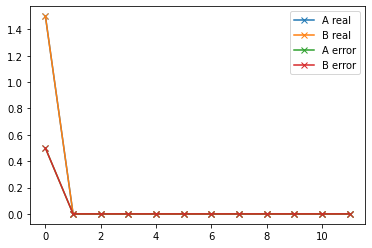

[ 1.99880059e+00+0.00000000e+00j  1.41376907e-17-2.50274825e-13j
 -1.02112341e-04+1.60702368e-04j  1.09771567e-17-2.55283630e-13j
  2.54759667e-09-4.00935701e-09j -5.45365075e-22+1.27382673e-17j
 -6.35598866e-14+1.00029289e-13j  2.03816011e-26-4.76711351e-22j
  1.58575305e-18-2.49562677e-18j  9.30671693e-31+1.58561138e-26j
 -3.95628880e-23+6.22632918e-23j  1.60814240e-30-2.33730457e-30j]
[ 1.99880059e+00+0.00000000e+00j -7.54010153e-18+2.56421888e-13j
 -1.02101509e-04-1.60774116e-04j -1.08863597e-17+2.55356859e-13j
  2.54732263e-09+4.01114083e-09j  5.43215402e-22-1.27419260e-17j
 -6.35529544e-14-1.00073638e-13j -2.03274312e-26+4.76848333e-22j
  1.58557772e-18+2.49672936e-18j  2.28437971e-30-1.58606715e-26j
 -3.95584537e-23-6.22907062e-23j  1.60809997e-30+2.33744685e-30j]


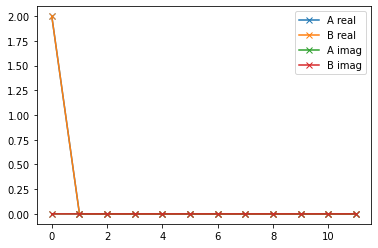

DONE


In [53]:
corrAAH = dict(np.load("./FULL_TEST/CORR_AAH_WE_00001.npz"))
corrAHA = dict(np.load("./FULL_TEST/CORR_AHA_WE_00001.npz"))
corr = {}
corr['corA'] = ((corrAAH['corA'] + corrAHA['corA']) / 2)
corr['corB'] = ((corrAAH['corB'] + corrAHA['corB']) / 2)
corr['errA'] = ((corrAAH['corA'] - corrAHA['corA']) / 2)
corr['errB'] = ((corrAAH['corB'] - corrAHA['corB']) / 2)
# print(corr['corA'])
# print(corr['corB'])
lim = 0.0025 / 4 / 5
# plt.ylim(-lim,lim)
delta = 1e-10
plt.plot(np.arange(0, len(corr['corA'])), corr['corA'].real + delta * 0, label="A real", marker='x')
plt.plot(np.arange(0, len(corr['corB'])), corr['corB'].real + delta * 1, label="B real", marker='x')
plt.plot(np.arange(0, len(corr['corA'])), corr['errA'].real + delta * 2, label="A error", marker='x')
plt.plot(np.arange(0, len(corr['corB'])), corr['errB'].real + delta * 3, label="B error", marker='x')
plt.legend()
plt.show()

corrT = corrAAH
print(corrT['corA'])
print(corrT['corB'])
plt.clf()
# plt.ylim(-lim,lim)
plt.plot(np.arange(0, len(corrT['corA'])), corrT['corA'].real + delta * 0, label="A real", marker='x')
plt.plot(np.arange(0, len(corrT['corB'])), corrT['corB'].real + delta * 1, label="B real", marker='x')
plt.plot(np.arange(0, len(corrT['corA'])), corrT['corA'].imag + delta * 2, label="A imag", marker='x')
plt.plot(np.arange(0, len(corrT['corB'])), corrT['corB'].imag + delta * 3, label="B imag", marker='x')
plt.legend()
plt.show()
print("DONE")

In [10]:
PEPS1 = dict(np.load("./FULL_TEST_SVDU/PEPS_00001.npz"))

A = PEPS1['A']
B = PEPS1['B']

D = A.shape[0]
d = A.shape[-1]

_, s, _ = svd(A.swapaxes(0, 1).reshape(D, D * D * D * d))
print(s)
_, s, _ = svd(A.swapaxes(0, 3).reshape(D, D * D * D * d))
print(s)
_, s, _ = svd(B.swapaxes(0, 1).reshape(D, D * D * D * d))
print(s)
_, s, _ = svd(B.swapaxes(0, 3).reshape(D, D * D * D * d))
print(s)

[0.98628524 0.11729818 0.11611447 0.         0.         0.
 0.         0.         0.        ]
[9.86286508e-01 1.16687722e-01 1.16687722e-01 1.66093318e-03
 1.19193648e-03 1.15682443e-03 1.15682443e-03 9.64312642e-05
 9.64312642e-05]
[9.86286508e-01 1.16687722e-01 1.16687722e-01 1.66093318e-03
 1.19193648e-03 1.15682443e-03 1.15682443e-03 9.64312642e-05
 9.64312642e-05]
[9.86285237e-01 1.17298180e-01 1.16114465e-01 9.85896193e-09
 9.85896193e-09 9.85891000e-09 9.85891000e-09 9.75947020e-09
 9.75947020e-09]


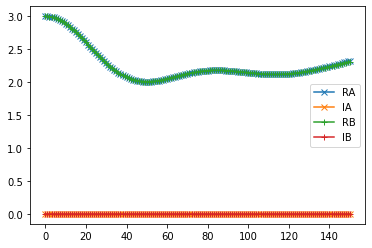

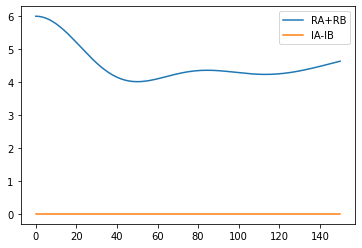

In [49]:
arA, arB = [], []
dist = 0

for i in range(151):
    corrAAH = dict(np.load("./FULL_TEST/CORR_AAH_WE_{:05d}.npz".format(i)))
    corrAHA = dict(np.load("./FULL_TEST/CORR_AHA_WE_{:05d}.npz".format(i)))
    corr = {'corA': (corrAAH['corA'] + corrAHA['corA']), 'corB': (corrAAH['corB'] + corrAHA['corB']),
            'errA': (corrAAH['corA'] - corrAHA['corA']), 'errB': (corrAAH['corB'] - corrAHA['corB'])}
    # print(corr['corA'])
    # print(corr['corB'])
    lim = 0.0025
    plt.ylim(-lim, lim)
    delta = 0.001 * 0

    arA.append(corr['corA'][dist])
    arB.append(corr['corB'][dist])

arA = np.array(arA)
arB = np.array(arB)

plt.clf()
plt.plot(np.arange(0, len(arA)), arA.real + 0.00, label='RA', marker='x')
plt.plot(np.arange(0, len(arA)), arA.imag + 0.00, label='IA', marker='x')
plt.plot(np.arange(0, len(arB)), arB.real + 0.00, label='RB', marker='+')
plt.plot(np.arange(0, len(arB)), arB.imag + 0.00, label='IB', marker='+')
plt.legend()
plt.show()

plt.clf()
plt.plot(np.arange(0, len(arA)), arA.real + arB.real, label='RA+RB')
plt.plot(np.arange(0, len(arA)), arA.imag - arB.imag, label='IA-IB')
plt.legend()
plt.show()

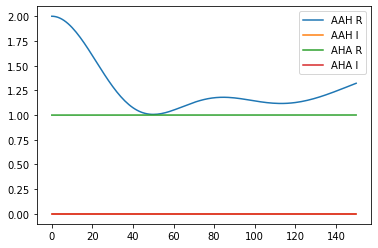

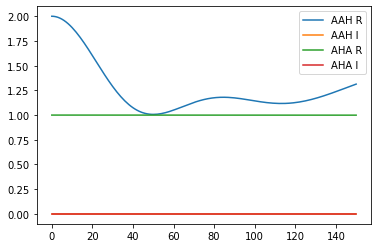

In [59]:
#KORELACJE DIST=0

E_AB_aah, E_AB_aha, E_BA_aah, E_BA_aha = [], [], [], []
for i in range(151):
    env = dict(np.load("./FULL_TEST/RHOA_{:05d}.npz".format(i)))

    a = np.diag(np.sqrt(np.arange(1, 3)), k=1)
    ah = a.T

    E_AB_aah.append(np.trace(env['rhoA'] @ a @ ah))
    E_AB_aha.append(np.trace(env['rhoA'] @ ah @ a))
    E_BA_aah.append(np.trace(env['rhoB'] @ a @ ah))
    E_BA_aha.append(np.trace(env['rhoB'] @ ah @ a))

E_AB_aah = np.array(E_AB_aah)
E_BA_aah = np.array(E_BA_aah)
E_AB_aha = np.array(E_AB_aha)
E_BA_aha = np.array(E_BA_aha)

plt.clf()
plt.plot(np.arange(0, len(arA)), E_AB_aah.real, label='AAH R')
plt.plot(np.arange(0, len(arA)), E_AB_aah.imag, label='AAH I')
plt.plot(np.arange(0, len(arB)), E_AB_aha.real, label='AHA R')
plt.plot(np.arange(0, len(arB)), E_AB_aha.imag, label='AHA I')
plt.legend()
plt.show()

plt.clf()
plt.plot(np.arange(0, len(arA)), E_BA_aah.real, label='AAH R')
plt.plot(np.arange(0, len(arA)), E_BA_aah.imag, label='AAH I')
plt.plot(np.arange(0, len(arB)), E_BA_aha.real, label='AHA R')
plt.plot(np.arange(0, len(arB)), E_BA_aha.imag, label='AHA I')
plt.legend()
plt.show()

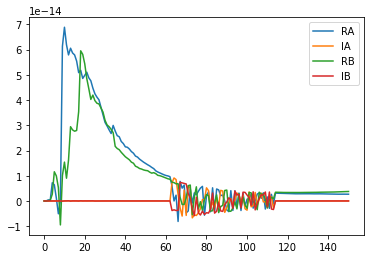

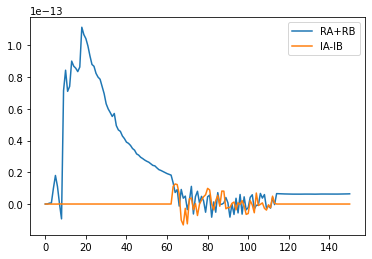

In [50]:
#KORELACJE DIST=1

arA, arB = [], []
for i in range(151):
    PEPS = dict(np.load("./FULL_TEST/PEPS_{:05d}.npz".format(i)))
    env = dict(np.load("./FULL_TEST/RHOA_{:05d}.npz".format(i)))

    a = np.diag(np.sqrt(np.arange(1, 3)), k=1)
    ah = a.T

    A = PEPS['A']
    B = PEPS['B']

    Aa = ncon([A, a], ([-1, -2, -3, -4, 1], [-5, 1]))
    Bah = ncon([B, ah], ([-1, -2, -3, -4, 1], [-5, 1]))
    Aah = ncon([A, ah], ([-1, -2, -3, -4, 1], [-5, 1]))
    Ba = ncon([B, a], ([-1, -2, -3, -4, 1], [-5, 1]))
    Ac = A.conj()
    Bc = B.conj()

    E_AB_aah = ncon(
        [env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'], env['E_E_A'], env['C_NE_B'], env['E_N_A'],
         env['E_N_B'], env['C_NW_A'], env['E_W_B'], Aa, Ac, Bah, Bc], (
            [2, 11], [11, 19, 9, 10], [19, 24, 17, 18], [24, 25], [25, 21, 22, 23], [21, 20], [20, 12, 13, 14],
            [12, 3, 4, 6], [3, 1], [1, 2, 5, 7], [4, 15, 9, 5, 8], [6, 16, 10, 7, 8], [13, 22, 17, 15, 26],
            [14, 23, 18, 16, 26]))
    E_AB_aha = ncon(
        [env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'], env['E_E_A'], env['C_NE_B'], env['E_N_A'],
         env['E_N_B'], env['C_NW_A'], env['E_W_B'], Aah, Ac, Ba, Bc], (
            [2, 11], [11, 19, 9, 10], [19, 24, 17, 18], [24, 25], [25, 21, 22, 23], [21, 20], [20, 12, 13, 14],
            [12, 3, 4, 6], [3, 1], [1, 2, 5, 7], [4, 15, 9, 5, 8], [6, 16, 10, 7, 8], [13, 22, 17, 15, 26],
            [14, 23, 18, 16, 26]))
    E_BA_aah = ncon(
        [env['C_SW_B'], env['E_S_A'], env['E_S_B'], env['C_SE_A'], env['E_E_B'], env['C_NE_A'], env['E_N_B'],
         env['E_N_A'], env['C_NW_B'], env['E_W_A'], Ba, Bc, Aah, Ac], (
            [2, 11], [11, 19, 9, 10], [19, 24, 17, 18], [24, 25], [25, 21, 22, 23], [21, 20], [20, 12, 13, 14],
            [12, 3, 4, 6], [3, 1], [1, 2, 5, 7], [4, 15, 9, 5, 8], [6, 16, 10, 7, 8], [13, 22, 17, 15, 26],
            [14, 23, 18, 16, 26]))
    E_BA_aha = ncon(
        [env['C_SW_B'], env['E_S_A'], env['E_S_B'], env['C_SE_A'], env['E_E_B'], env['C_NE_A'], env['E_N_B'],
         env['E_N_A'], env['C_NW_B'], env['E_W_A'], Bah, Bc, Aa, Ac], (
            [2, 11], [11, 19, 9, 10], [19, 24, 17, 18], [24, 25], [25, 21, 22, 23], [21, 20], [20, 12, 13, 14],
            [12, 3, 4, 6], [3, 1], [1, 2, 5, 7], [4, 15, 9, 5, 8], [6, 16, 10, 7, 8], [13, 22, 17, 15, 26],
            [14, 23, 18, 16, 26]))

    arA.append(E_AB_aha + E_AB_aah)
    arB.append(E_BA_aha + E_BA_aah)

arA = np.array(arA)
arB = np.array(arB)

plt.clf()
plt.plot(np.arange(0, len(arA)), arA.real + 0.00, label='RA')
plt.plot(np.arange(0, len(arA)), arA.imag + 0.00, label='IA')
plt.plot(np.arange(0, len(arB)), arB.real + 0.00, label='RB')
plt.plot(np.arange(0, len(arB)), arB.imag + 0.00, label='IB')
plt.legend()
plt.show()

plt.clf()
plt.plot(np.arange(0, len(arA)), arA.real + arB.real, label='RA+RB')
plt.plot(np.arange(0, len(arA)), arA.imag - arB.imag, label='IA-IB')
plt.legend()
plt.show()

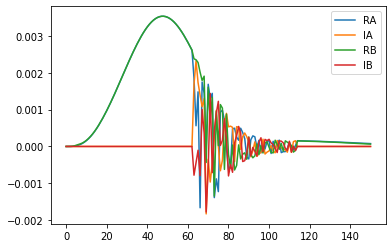

In [31]:
#KORELACJE DIST = 2

arABA_aah, arABA_aha, arBAB_aah, arBAB_aha = [], [], [], []
for i in range(151):
    PEPS = dict(np.load("./FULL_TEST/PEPS_{:05d}.npz".format(i)))
    env = dict(np.load("./FULL_TEST/RHOA_{:05d}.npz".format(i)))

    a = np.diag(np.sqrt(np.arange(1, 3)), k=1)
    ah = a.T

    A = PEPS['A']
    B = PEPS['B']

    Aa = ncon([A, a], ([-1, -2, -3, -4, 1], [-5, 1]))
    Bah = ncon([B, ah], ([-1, -2, -3, -4, 1], [-5, 1]))
    Aah = ncon([A, ah], ([-1, -2, -3, -4, 1], [-5, 1]))
    Ba = ncon([B, a], ([-1, -2, -3, -4, 1], [-5, 1]))
    Ac = A.conj()
    Bc = B.conj()

    tensors = [env['C_NW_B'], env['E_W_A'], env['C_SW_B'], env['E_S_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'],
               env['E_E_A'], env['C_NE_B'], env['E_N_A'], env['E_N_B'], env['E_N_A'], Ba, Bc, A, Ac, Bah, Bc]
    cons = (
        [3, 1], [1, 2, 6, 7], [2, 11], [11, 20, 9, 10], [20, 29, 18, 19], [29, 35, 27, 28], [35, 34], [34, 31, 32, 33],
        [31, 30], [30, 21, 22, 23], [21, 12, 13, 14], [12, 3, 4, 5], [4, 15, 9, 6, 8], [5, 16, 10, 7, 8],
        [13, 24, 18, 15, 17], [14, 25, 19, 16, 17], [22, 32, 27, 24, 26], [23, 33, 28, 25, 26])
    E_BAB_aah = ncon(
        [env['C_NW_B'], env['E_W_A'], env['C_SW_B'], env['E_S_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'],
         env['E_E_A'], env['C_NE_B'], env['E_N_A'], env['E_N_B'], env['E_N_A'], Ba, Bc, A, Ac, Bah, Bc], (
            [3, 1], [1, 2, 6, 7], [2, 11], [11, 20, 9, 10], [20, 29, 18, 19], [29, 35, 27, 28], [35, 34],
            [34, 31, 32, 33],
            [31, 30], [30, 21, 22, 23], [21, 12, 13, 14], [12, 3, 4, 5], [4, 15, 9, 6, 8], [5, 16, 10, 7, 8],
            [13, 24, 18, 15, 17], [14, 25, 19, 16, 17], [22, 32, 27, 24, 26], [23, 33, 28, 25, 26]))
    E_ABA_aah = ncon(
        [env['C_NW_A'], env['E_W_B'], env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['E_S_B'], env['C_SE_A'],
         env['E_E_B'], env['C_NE_A'], env['E_N_B'], env['E_N_A'], env['E_N_B'], Aa, Ac, B, Bc, Aah, Ac], (
            [3, 1], [1, 2, 6, 7], [2, 11], [11, 20, 9, 10], [20, 29, 18, 19], [29, 35, 27, 28], [35, 34],
            [34, 31, 32, 33],
            [31, 30], [30, 21, 22, 23], [21, 12, 13, 14], [12, 3, 4, 5], [4, 15, 9, 6, 8], [5, 16, 10, 7, 8],
            [13, 24, 18, 15, 17], [14, 25, 19, 16, 17], [22, 32, 27, 24, 26], [23, 33, 28, 25, 26]))
    E_BAB_aha = ncon(
        [env['C_NW_B'], env['E_W_A'], env['C_SW_B'], env['E_S_A'], env['E_S_B'], env['E_S_A'], env['C_SE_B'],
         env['E_E_A'], env['C_NE_B'], env['E_N_A'], env['E_N_B'], env['E_N_A'], Bah, Bc, A, Ac, Ba, Bc], (
            [3, 1], [1, 2, 6, 7], [2, 11], [11, 20, 9, 10], [20, 29, 18, 19], [29, 35, 27, 28], [35, 34],
            [34, 31, 32, 33],
            [31, 30], [30, 21, 22, 23], [21, 12, 13, 14], [12, 3, 4, 5], [4, 15, 9, 6, 8], [5, 16, 10, 7, 8],
            [13, 24, 18, 15, 17], [14, 25, 19, 16, 17], [22, 32, 27, 24, 26], [23, 33, 28, 25, 26]))
    E_ABA_aha = ncon(
        [env['C_NW_A'], env['E_W_B'], env['C_SW_A'], env['E_S_B'], env['E_S_A'], env['E_S_B'], env['C_SE_A'],
         env['E_E_B'], env['C_NE_A'], env['E_N_B'], env['E_N_A'], env['E_N_B'], Aah, Ac, B, Bc, Aa, Ac], (
            [3, 1], [1, 2, 6, 7], [2, 11], [11, 20, 9, 10], [20, 29, 18, 19], [29, 35, 27, 28], [35, 34],
            [34, 31, 32, 33],
            [31, 30], [30, 21, 22, 23], [21, 12, 13, 14], [12, 3, 4, 5], [4, 15, 9, 6, 8], [5, 16, 10, 7, 8],
            [13, 24, 18, 15, 17], [14, 25, 19, 16, 17], [22, 32, 27, 24, 26], [23, 33, 28, 25, 26]))

    # E_AB_aah = ncon([],)

    arABA_aah.append(E_ABA_aah)
    arBAB_aah.append(E_BAB_aah)
    arABA_aha.append(E_ABA_aha)
    arBAB_aha.append(E_BAB_aha)

arABA_aah = np.array(arABA_aah)
arBAB_aah = np.array(arBAB_aah)
arABA_aha = np.array(arABA_aha)
arBAB_aha = np.array(arBAB_aha)

plt.clf()
# plt.xlim(0,len(arBAB_aah))
# plt.ylim(0,(arABA_aah.real+arABA_aha.real)[-1])
plt.plot(np.arange(0, len(arABA_aah)), arABA_aah.real + arABA_aha.real, label='RA')
plt.plot(np.arange(0, len(arABA_aah)), arABA_aah.imag + arABA_aha.imag, label='IA')
plt.plot(np.arange(0, len(arBAB_aah)), arBAB_aah.real + arBAB_aha.real, label='RB')
plt.plot(np.arange(0, len(arBAB_aah)), arBAB_aah.imag + arBAB_aha.imag, label='IB')
plt.legend()
plt.show()

# plt.clf()
# plt.plot(np.arange(0,len(arA)),arA.real+arB.real, label='RA+RB')
# plt.plot(np.arange(0,len(arA)),arA.imag-arB.imag, label='IA-IB')
# plt.legend()
# plt.show()

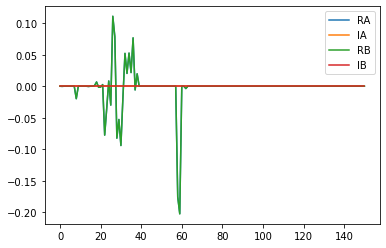

In [32]:
arABA_aah, arABA_aha, arBAB_aah, arBAB_aha = [], [], [], []
for i in range(151):
    corsAAH = dict(np.load("./FULL_TEST/CORR_AAH_WE_{:05d}.npz".format(i)))
    corsAHA = dict(np.load("./FULL_TEST/CORR_AHA_WE_{:05d}.npz".format(i)))

    arABA_aah.append(corsAAH['corA'][2])
    arBAB_aah.append(corsAAH['corB'][2])
    arABA_aha.append(corsAHA['corA'][2])
    arBAB_aha.append(corsAHA['corB'][2])

arABA_aah = np.array(arABA_aah)
arBAB_aah = np.array(arBAB_aah)
arABA_aha = np.array(arABA_aha)
arBAB_aha = np.array(arBAB_aha)

plt.clf()
# plt.xlim(0,len(arBAB_aah))
# plt.ylim(0,(arABA_aah.real+arABA_aha.real)[-1])
plt.plot(np.arange(0, len(arABA_aah)), arABA_aah.real + arABA_aha.real, label='RA')
plt.plot(np.arange(0, len(arABA_aah)), arABA_aah.imag + arABA_aha.imag, label='IA')
plt.plot(np.arange(0, len(arBAB_aah)), arBAB_aah.real + arBAB_aha.real, label='RB')
plt.plot(np.arange(0, len(arBAB_aah)), arBAB_aah.imag + arBAB_aha.imag, label='IB')
plt.legend()
plt.show()

# plt.clf()
# plt.plot(np.arange(0,len(arA)),arA.real+arB.real, label='RA+RB')
# plt.plot(np.arange(0,len(arA)),arA.imag-arB.imag, label='IA-IB')
# plt.legend()
# plt.show()

In [60]:
exponent = 2
dt = 10 ** (-exponent)
dt

0.01

In [8]:
PEPS = BoseHubbard.TrotterGate(3, 9, 0.1 * 19.6, J=1 / 19.6, U=1)
GA = PEPS['GA']
GB = PEPS['GB']
H1 = ncon([GA, GB], ([-1, -3, 1], [-2, -4, 1]))
H2 = ncon([GB, GA], ([-1, -3, 1], [-2, -4, 1]))
print(norm(H1 - H2))

6.133466154461151e-16


In [9]:
a = np.diag(np.sqrt(np.arange(1, 3)), k=1)
a

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.41421356],
       [0.        , 0.        , 0.        ]])

In [20]:
d = 3

a = np.diag(np.sqrt(np.arange(1, d)), k=1)
ah = a.T
n = ah @ a
nn = n @ n
I = np.eye(d)

if r > d ** 2: r = d ** 2

HJ = -J * (np.einsum('ij,kl->jlik', a, ah) + np.einsum('ij,kl->jlik', ah, a)) / 2
HU = U / 2 * (nn - n) - mu * n

GA, GB = Tools.truncate2(
    expm(-1j * dt * HJ.reshape(d * d, d * d)).reshape(d, d, d, d).swapaxes(1, 2).reshape(d * d, d * d), r)
GU = expm(-1j * dt / 2 * HU)

GA = GA.reshape(d, d, r)
GB = GB.T.reshape(d, d, r)
GA = ncon([GU, GA, GU], ([-2, 2], [2, 1, -3], [1, -1]))
GB = ncon([GU, GB, GU], ([-2, 2], [2, 1, -3], [1, -1]))

{'A': array([[[[[-1.60848132e-09+4.79281186e-09j,
            -9.73098819e-01-3.58768923e-05j,
            -7.80069010e-10-2.05411009e-09j],
           [-5.94400722e-02-5.32417600e-02j,
             1.15715556e-07-2.61782859e-09j,
             7.50350579e-03+1.05096270e-02j],
           [ 9.87307534e-03-8.21482721e-03j,
             6.25030547e-08-4.93793277e-10j,
             7.13969934e-02-3.65974747e-02j],
           ...,
           [-1.53244616e-07-1.88201313e-06j,
             1.96756521e-08-6.79773852e-08j,
             1.00772162e-07-6.77549357e-07j],
           [-1.82294117e-07+5.90491585e-07j,
            -1.05659022e-08+1.75519377e-08j,
             6.21694506e-09+3.65542151e-07j],
           [-2.41644790e-07+4.47400190e-07j,
            -1.34926924e-08+1.10951553e-08j,
            -1.89021234e-08+1.61317657e-07j]],
 
          [[-4.18398530e-04-1.30203480e-02j,
             4.08484021e-08+2.30737918e-10j,
            -7.76659041e-02+1.49770360e-02j],
           [ 2.20708591e

In [2]:
def __CTMRT_left(A, B, chi, env={}, invprecision=1e-10, ifprint=False, ifrandom=False):
    t0 = time()
    D = A.shape[0]
    d = A.shape[-1]

    if ifrandom:
        env = {'E_E_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_E_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_W_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_W_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_S_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_S_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_N_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_N_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'C_NW_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SW_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_NE_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SE_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_NW_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SW_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_NE_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SE_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi)}

    if len(env) == 0:
        if chi <= D ** 2:
            # temp = A.swapaxes(3,2).swapaxes(2,1).swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NW_A = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).reshape(D*D,D*D)
            # temp = B.swapaxes(3,2).swapaxes(2,1).swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NW_B = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).reshape(D*D,D*D)
            # temp = A.swapaxes(4,3).swapaxes(3,2).swapaxes(2,1).reshape(D*d,D*D*D)
            # E_N_A = (temp.conj().T @ temp).reshape(D,D,D,D,D,D).swapaxes(2,3).swapaxes(3,4).swapaxes(4,5).swapaxes(3,4).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3).swapaxes(1,2).reshape(D**2,D**2,D,D)
            # temp = B.swapaxes(4,3).swapaxes(3,2).swapaxes(2,1).reshape(D*d,D*D*D)
            # E_N_B = (temp.conj().T @ temp).reshape(D,D,D,D,D,D).swapaxes(2,3).swapaxes(3,4).swapaxes(4,5).swapaxes(3,4).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3).swapaxes(1,2).reshape(D**2,D**2,D,D)
            #
            # # work in progress, watch your step
            # temp = A.swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NE_A = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).swapaxes(1,3).swapaxes(3,4).reshape(D*D,D*D)
            # temp = B.swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NE_B = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).swapaxes(1,3).swapaxes(3,4).reshape(D*D,D*D)
            # temp = A.

            C_NW_A = ncon([A, A.conj()], ([1, -1, -3, 2, 3], [1, -2, -4, 2, 3])).reshape(D * D, D * D)
            C_NW_B = ncon([B, B.conj()], ([1, -1, -3, 2, 3], [1, -2, -4, 2, 3])).reshape(D * D, D * D)
            C_NE_A = ncon([A, A.conj()], ([1, 2, -1, -3, 3], [1, 2, -2, -4, 3])).reshape(D * D, D * D)
            C_NE_B = ncon([B, B.conj()], ([1, 2, -1, -3, 3], [1, 2, -2, -4, 3])).reshape(D * D, D * D)
            C_SW_A = ncon([A, A.conj()], ([-1, -3, 1, 2, 3], [-2, -4, 1, 2, 3])).reshape(D * D, D * D)
            C_SW_B = ncon([B, B.conj()], ([-1, -3, 1, 2, 3], [-2, -4, 1, 2, 3])).reshape(D * D, D * D)
            C_SE_A = ncon([A, A.conj()], ([-1, 1, 2, -3, 3], [-2, 1, 2, -4, 3])).reshape(D * D, D * D)
            C_SE_B = ncon([B, B.conj()], ([-1, 1, 2, -3, 3], [-2, 1, 2, -4, 3])).reshape(D * D, D * D)

            E_E_A = ncon([A, A.conj()], ([-3, 1, -1, -5, 2], [-4, 1, -2, -6, 2])).reshape(D * D, D * D, D, D)
            E_E_B = ncon([B, B.conj()], ([-3, 1, -1, -5, 2], [-4, 1, -2, -6, 2])).reshape(D * D, D * D, D, D)
            E_N_A = ncon([A, A.conj()], ([1, -1, -5, -3, 2], [1, -2, -6, -4, 2])).reshape(D * D, D * D, D, D)
            E_N_B = ncon([B, B.conj()], ([1, -1, -5, -3, 2], [1, -2, -6, -4, 2])).reshape(D * D, D * D, D, D)
            E_W_A = ncon([A, A.conj()], ([-1, -5, -3, 1, 2], [-2, -6, -4, 1, 2])).reshape(D * D, D * D, D, D)
            E_W_B = ncon([B, B.conj()], ([-1, -5, -3, 1, 2], [-2, -6, -4, 1, 2])).reshape(D * D, D * D, D, D)
            E_S_A = ncon([A, A.conj()], ([-5, -3, 1, -1, 2], [-6, -4, 1, -2, 2])).reshape(D * D, D * D, D, D)
            E_S_B = ncon([B, B.conj()], ([-5, -3, 1, -1, 2], [-6, -4, 1, -2, 2])).reshape(D * D, D * D, D, D)

        if chi <= D ** 4 and chi > D ** 2:
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[15, 5, 6, 14, 1], [15, 10, 11, 14, 1], [16, -1, 8, 5, 2], [16, -3, 9, 10, 2],
                        [6, 7, -5, 13, 4], [11, 12, -7, 13, 4], [8, -2, -6, 7, 3], [9, -4, -8, 12, 3]]
            con_order = [15, 14, 1, 16, 2, 13, 4, 5, 10, 6, 11, 8, 7, 9, 12, 3]
            C_NW_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[-1, 5, 6, 16, 1], [-3, 10, 11, 16, 1], [-2, -6, 8, 5, 2], [-4, -8, 9, 10, 2],
                        [6, 7, 14, 15, 4], [11, 12, 14, 15, 4], [8, -5, 13, 7, 3], [9, -7, 13, 12, 3]]
            con_order = [16, 1, 13, 3, 14, 15, 4, 7, 12, 6, 11, 10, 9, 5, 8, 2]
            C_SW_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[-6, 5, 6, -2, 1], [-8, 10, 11, -4, 1], [-5, 13, 8, 5, 2], [-7, 13, 9, 10, 2],
                        [6, 7, 16, -1, 4], [11, 12, 16, -3, 4], [8, 14, 15, 7, 3], [9, 14, 15, 12, 3]]
            con_order = [16, 4, 14, 15, 3, 13, 2, 7, 12, 8, 9, 5, 6, 1, 10, 11]
            C_SE_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[13, 5, 6, -5, 1], [13, 10, 11, -7, 1], [14, 15, 8, 5, 2], [14, 15, 9, 10, 2],
                        [6, 7, -2, -6, 4], [11, 12, -4, -8, 4], [8, 16, -1, 7, 3], [9, 16, -3, 12, 3]]
            con_order = [13, 1, 14, 15, 2, 16, 3, 8, 9, 5, 10, 6, 7, 11, 12, 4]
            C_NE_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[15, 5, 6, 14, 1], [15, 10, 11, 14, 1], [16, -1, 8, 5, 2], [16, -3, 9, 10, 2],
                        [6, 7, -5, 13, 4], [11, 12, -7, 13, 4], [8, -2, -6, 7, 3], [9, -4, -8, 12, 3]]
            con_order = [15, 14, 1, 16, 2, 13, 4, 5, 10, 6, 11, 8, 7, 9, 12, 3]
            C_NW_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[-1, 5, 6, 16, 1], [-3, 10, 11, 16, 1], [-2, -6, 8, 5, 2], [-4, -8, 9, 10, 2],
                        [6, 7, 14, 15, 4], [11, 12, 14, 15, 4], [8, -5, 13, 7, 3], [9, -7, 13, 12, 3]]
            con_order = [16, 1, 13, 3, 14, 15, 4, 7, 12, 6, 11, 10, 9, 5, 8, 2]
            C_SW_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[-6, 5, 6, -2, 1], [-8, 10, 11, -4, 1], [-5, 13, 8, 5, 2], [-7, 13, 9, 10, 2],
                        [6, 7, 16, -1, 4], [11, 12, 16, -3, 4], [8, 14, 15, 7, 3], [9, 14, 15, 12, 3]]
            con_order = [16, 4, 14, 15, 3, 13, 2, 7, 12, 8, 9, 5, 6, 1, 10, 11]
            C_SE_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[13, 5, 6, -5, 1], [13, 10, 11, -7, 1], [14, 15, 8, 5, 2], [14, 15, 9, 10, 2],
                        [6, 7, -2, -6, 4], [11, 12, -4, -8, 4], [8, 16, -1, 7, 3], [9, 16, -3, 12, 3]]
            con_order = [13, 1, 14, 15, 2, 16, 3, 8, 9, 5, 10, 6, 7, 11, 12, 4]
            C_NE_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[-1, 3, -5, 5, 2], [-3, 4, -7, 5, 2], [-2, -9, -6, 3, 1], [-4, -10, -8, 4, 1]]
            con_order = [5, 2, 4, 3, 1]
            E_W_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[-1, 3, -5, 5, 1], [-3, 4, -7, 5, 1], [-2, -9, -6, 3, 2], [-4, -10, -8, 4, 2]]
            con_order = [5, 1, 4, 3, 2]
            E_W_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[-6, 3, -2, -9, 1], [-8, 4, -4, -10, 1], [-5, 5, -1, 3, 2], [-7, 5, -3, 4, 2]]
            con_order = [5, 2, 3, 1, 4]
            E_E_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[-6, 3, -2, -9, 2], [-8, 4, -4, -10, 2], [-5, 5, -1, 3, 1], [-7, 5, -3, 4, 1]]
            con_order = [5, 1, 3, 2, 4]
            E_E_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[5, -1, 3, -5, 1], [5, -3, 4, -7, 1], [3, -2, -9, -6, 2], [4, -4, -10, -8, 2]]
            con_order = [5, 1, 4, 3, 2]
            E_N_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[-9, -6, 3, -2, 1], [-10, -8, 4, -4, 1], [3, -5, 5, -1, 2], [4, -7, 5, -3, 2]]
            con_order = [5, 2, 4, 3, 1]
            E_S_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[-9, -6, 3, -2, 1], [-10, -8, 4, -4, 1], [3, -5, 5, -1, 2], [4, -7, 5, -3, 2]]
            con_order = [5, 2, 3, 1, 4]
            E_S_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[5, -1, 3, -5, 1], [5, -3, 4, -7, 1], [3, -2, -9, -6, 2], [4, -4, -10, -8, 2]]
            con_order = [5, 1, 3, 4, 2]
            E_N_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)

        E_E_A = E_E_A[:chi, :chi, :, :] / norm(E_E_A)
        E_E_B = E_E_B[:chi, :chi, :, :] / norm(E_E_B)
        E_W_A = E_W_A[:chi, :chi, :, :] / norm(E_W_A)
        E_W_B = E_W_B[:chi, :chi, :, :] / norm(E_W_B)
        E_S_A = E_S_A[:chi, :chi, :, :] / norm(E_S_A)
        E_S_B = E_S_B[:chi, :chi, :, :] / norm(E_S_B)
        E_N_A = E_N_A[:chi, :chi, :, :] / norm(E_N_A)
        E_N_B = E_N_B[:chi, :chi, :, :] / norm(E_N_B)
        C_NW_A = C_NW_A[:chi, :chi] / norm(C_NW_A)
        C_NE_B = C_NE_B[:chi, :chi] / norm(C_NE_B)
        C_SE_A = C_SE_A[:chi, :chi] / norm(C_SE_A)
        C_SW_B = C_SW_B[:chi, :chi] / norm(C_SW_B)
        C_NW_B = C_NW_B[:chi, :chi] / norm(C_NW_B)
        C_NE_A = C_NE_A[:chi, :chi] / norm(C_NE_A)
        C_SE_B = C_SE_B[:chi, :chi] / norm(C_SE_B)
        C_SW_A = C_SW_A[:chi, :chi] / norm(C_SW_A)

    else:
        E_E_A = env['E_E_A']
        E_E_B = env['E_E_B']
        E_W_A = env['E_W_A']
        E_W_B = env['E_W_B']
        E_S_A = env['E_S_A']
        E_S_B = env['E_S_B']
        E_N_A = env['E_N_A']
        E_N_B = env['E_N_B']
        C_NW_A = env['C_NW_A']
        C_NE_B = env['C_NE_B']
        C_SE_A = env['C_SE_A']
        C_SW_B = env['C_SW_B']
        C_NW_B = env['C_NW_B']
        C_NE_A = env['C_NE_A']
        C_SE_B = env['C_SE_B']
        C_SW_A = env['C_SW_A']

    # errora, errorb = 1000000000, 1000000000
    #
    # tensors = [C_NW_A, A, E_N_B, C_SW_A, E_W_B, C_SE_A, E_S_B, C_NE_A, E_E_B, A.conj()]
    # connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
    #             [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    # con_order = [4, 3, 2, 7, 10, 11, 16, 6, 5, 1, 14, 13, 9, 8, 15, 12]
    # rhoA = ncon(tensors, connects, con_order)
    #
    # tensors = [C_NW_B, B, E_N_A, C_SW_B, E_W_A, C_SE_B, E_S_A, C_NE_B, E_E_A, B.conj()]
    # connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
    #             [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    # con_order = [1, 7, 5, 3, 2, 6, 13, 14, 4, 10, 11, 16, 9, 8, 12, 15]
    # rhoB = ncon(tensors, connects, con_order)
    #
    # rhoA = rhoA / np.trace(rhoA)
    # rhoA = (rhoA + rhoA.conj().T) / 2
    # print(rhoA)
    # rhoB = rhoB / np.trace(rhoB)
    # rhoB = (rhoB + rhoB.conj().T) / 2
    # print(rhoB)

    t0 = time()
    if ifprint: print("\t##################################################")

    if False:
        print("A:", A.shape)
        print("B:", B.shape)

        print("C_NW_A:", C_NW_A.shape)
        print("C_NW_B:", C_NW_B.shape)
        print("C_SW_A:", C_SW_A.shape)
        print("C_SW_B:", C_SW_B.shape)
        print("C_NE_A:", C_NW_A.shape)
        print("C_NE_B:", C_NW_B.shape)
        print("C_SE_A:", C_SW_A.shape)
        print("C_SE_B:", C_SW_B.shape)

        print("E_W_A:", E_W_A.shape)
        print("E_W_B:", E_W_B.shape)
        print("E_S_A:", E_S_A.shape)
        print("E_S_B:", E_S_B.shape)
        print("E_N_A:", E_N_A.shape)
        print("E_N_B:", E_N_B.shape)
        print("E_E_A:", E_E_A.shape)
        print("E_E_B:", E_E_B.shape)

    if ifprint: print(time() - t0, "s")
    t0 = time()

    tensors = [C_NW_A, A, E_N_B, E_N_A, E_W_B, C_NE_B, E_E_A, A.conj(), B, B.conj()]
    connects = [[3, 4], [10, 7, -5, 11, 5], [2, 3, 10, 13], [1, 2, 9, 14], [4, -4, 11, 12], [17, 1],
                [-1, 17, 16, 15], [13, 8, -6, 12, 5], [9, 16, -2, 7, 6], [14, 15, -3, 8, 6]]
    con_order = [3, 4, 13, 12, 1, 17, 14, 15, 10, 11, 5, 9, 16, 6, 2, 8, 7]
    UpperHalfA = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)
    tensors = [C_SW_B, E_W_A, C_SE_A, E_S_B, E_S_A, E_E_B, B, B.conj(), A, A.conj()]
    connects = [[1, 2], [-4, 1, 10, 11], [4, 5], [3, 4, 15, 14], [2, 3, 12, 13], [5, -1, 17, 16],
                [-5, 8, 12, 10, 7], [-6, 9, 13, 11, 7], [-2, 17, 15, 8, 6], [-3, 16, 14, 9, 6]]
    con_order = [1, 5, 4, 17, 15, 2, 11, 13, 10, 12, 7, 16, 14, 6, 3, 9, 8]
    BottomHalfA = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)

    tensors = [C_NW_B, B, E_N_A, E_N_B, E_W_A, C_NE_A, E_E_B, B.conj(), A, A.conj()]
    connects = [[3, 4], [10, 7, -5, 11, 5], [2, 3, 10, 13], [1, 2, 9, 14], [4, -4, 11, 12], [17, 1],
                [-1, 17, 16, 15], [13, 8, -6, 12, 5], [9, 16, -2, 7, 6], [14, 15, -3, 8, 6]]
    con_order = [3, 4, 13, 12, 1, 17, 14, 15, 10, 11, 5, 9, 16, 6, 2, 8, 7]
    UpperHalfB = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)
    tensors = [C_SW_A, E_W_B, C_SE_B, E_S_A, E_S_B, E_E_A, A, A.conj(), B, B.conj()]
    connects = [[1, 2], [-4, 1, 10, 11], [4, 5], [3, 4, 15, 14], [2, 3, 12, 13], [5, -1, 17, 16],
                [-5, 8, 12, 10, 7], [-6, 9, 13, 11, 7], [-2, 17, 15, 8, 6], [-3, 16, 14, 9, 6]]
    con_order = [1, 5, 4, 17, 15, 2, 11, 13, 10, 12, 7, 16, 14, 6, 3, 9, 8]
    BottomHalfB = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)

    if ifprint: print("\tHalves calculated")

    if ifprint: print(time() - t0, "s")
    t0 = time()

    # tensors = [C_NW_A, A, E_N_B, C_SW_B, E_W_A, E_W_B, E_S_A, A.conj(), B, B.conj()]
    # connects = [[1, 2], [10, -2, 8, 11, 6], [-1, 1, 10, 14], [4, 5], [3, 4, 12, 15], [2, 3, 11, 13],
    #             [5, -4, 16, 17], [14, -3, 9, 13, 6], [8, -5, 16, 12, 7], [9, -6, 17, 15, 7]]
    # con_order = [5, 2, 1, 11, 10, 4, 17, 15, 16, 12, 7, 13, 14, 6, 3, 8, 9]
    # LeftHalf = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)
    # tensors = [E_N_A, C_SE_A, E_S_B, C_NE_B, E_E_A, E_E_B, B, B.conj(), A, A.conj()]
    # connects = [[1, -4, 9, 10], [2, 3], [-1, 2, 12, 11], [17, 1], [4, 17, 16, 15], [3, 4, 14, 13],
    #             [9, 16, 7, -5, 5], [10, 15, 8, -6, 5], [7, 14, 12, -2, 6], [8, 13, 11, -3, 6]]
    # con_order = [1, 3, 17, 9, 16, 2, 14, 12, 13, 11, 6, 10, 15, 5, 4, 7, 8]
    # RightHalf = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)

    # -R=
    RUA = qr(UpperHalfA.T, mode='r')
    RUB = qr(UpperHalfB.T, mode='r')
    RBA = qr(BottomHalfA.T, mode='r')
    RBB = qr(BottomHalfB.T, mode='r')

    if ifprint: print("\tQR done")

    if ifprint: print(time() - t0, "s")
    t0 = time()

    # =P-
    def create_isometries(X1, X2):
        # -X1= to ta górna macierz w CTMRG_BY_QR
        u, s, vh = truncate3((X1 @ X2.T).T, chi)
        s = np.where(s < s[0] * invprecision, 0, 1 / np.sqrt(s))
        if ifprint: print("\t", s)
        s = np.diag(s)
        p2 = (s @ u.conj().T @ X1).T.reshape(chi, D, D, chi)
        p1 = (s @ vh.conj() @ X2).T.reshape(chi, D, D, chi)
        return p1, p2

    P1A, P2A = create_isometries(RUA[0], RBA[0])
    P1B, P2B = create_isometries(RUB[0], RBB[0])
    # if ifprint: print((ncon([P1A,P2A],([-1,-2,-3,1],[-4,-5,-6,1]))).reshape(chi*D*D,chi*D*D))
    # if ifprint: print((ncon([P1B,P2B],([-1,-2,-3,1],[-4,-5,-6,1]))).reshape(chi*D*D,chi*D*D))

    if ifprint: print("\tIsometries calculated")

    if ifprint: print(time() - t0, "s")
    t0 = time()

    # Uppercorner
    C_NW_A_new = (P1A.reshape(chi * D * D, chi).T @ ncon([C_NW_B, E_N_A], ([1, -1], [-4, 1, -2, -3])).reshape(
        chi * D * D, chi)).T
    C_NW_B_new = (P1B.reshape(chi * D * D, chi).T @ ncon([C_NW_A, E_N_B], ([1, -1], [-4, 1, -2, -3])).reshape(
        chi * D * D, chi)).T

    # Lowercorner
    C_SW_A_new = P2B.reshape(chi * D * D, chi).T @ ncon([C_SW_B, E_S_A], ([-1, 1], [1, -4, -2, -3])).reshape(
        chi * D * D, chi)
    C_SW_B_new = P2A.reshape(chi * D * D, chi).T @ ncon([C_SW_A, E_S_B], ([-1, 1], [1, -4, -2, -3])).reshape(
        chi * D * D, chi)

    # Edge
    tensors = [P2A, P1B, E_W_B, A, A.conj()]
    connects = [[1, 7, 6, -1], [2, 8, 5, -2], [1, 2, 3, 4], [7, -3, 8, 3, 9], [6, -4, 5, 4, 9]]
    con_order = [2, 8, 3, 5, 4, 9, 1, 7, 6]
    E_W_A_new = ncon(tensors, connects, con_order)
    tensors = [P2B, P1A, E_W_A, B, B.conj()]
    connects = [[1, 7, 6, -1], [2, 8, 5, -2], [1, 2, 3, 4], [7, -3, 8, 3, 9], [6, -4, 5, 4, 9]]
    con_order = [2, 8, 3, 5, 4, 9, 1, 7, 6]
    E_W_B_new = ncon(tensors, connects, con_order)

    E_W_A = E_W_A_new / norm(E_W_A_new)
    E_W_B = E_W_B_new / norm(E_W_B_new)
    C_NW_A = C_NW_A_new / norm(C_NW_A_new)
    C_SW_B = C_SW_B_new / norm(C_SW_B_new)
    C_NW_B = C_NW_B_new / norm(C_NW_B_new)
    C_SW_A = C_SW_A_new / norm(C_SW_A_new)

    if ifprint: print("\tTensors updated")

    if ifprint: print(time() - t0, "s")
    t0 = time()

    tensors = [C_NW_A, A, E_N_B, C_SW_A, E_W_B, C_SE_A, E_S_B, C_NE_A, E_E_B, A.conj()]
    connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
                [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    con_order = [4, 3, 2, 7, 10, 11, 16, 6, 5, 1, 14, 13, 9, 8, 15, 12]
    rhoA = ncon(tensors, connects, con_order)

    tensors = [C_NW_B, B, E_N_A, C_SW_B, E_W_A, C_SE_B, E_S_A, C_NE_B, E_E_A, B.conj()]
    connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
                [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    con_order = [1, 7, 5, 3, 2, 6, 13, 14, 4, 10, 11, 16, 9, 8, 12, 15]
    rhoB = ncon(tensors, connects, con_order)

    rhoA = rhoA / np.trace(rhoA)
    rhoA = (rhoA + rhoA.conj().T) / 2
    if ifprint: print("\t", rhoA)
    rhoB = rhoB / np.trace(rhoB)
    rhoB = (rhoB + rhoB.conj().T) / 2
    if ifprint: print("\t", rhoB)

    if ifprint: print("\tDensity matricies calculated")

    if ifprint: print(time() - t0, "s")
    t0 = time()

    if ifprint: print("\t ---", time() - t0, "s")

    return {'E_E_A': E_E_A, 'E_E_B': E_E_B, 'E_W_A': E_W_A, 'E_W_B': E_W_B, 'E_S_A': E_S_A, 'E_S_B': E_S_B,
            'E_N_A': E_N_A, 'E_N_B': E_N_B, 'C_NW_A': C_NW_A, 'C_SW_B': C_SW_B, 'C_NE_B': C_NE_B, 'C_SE_A': C_SE_A,
            'C_NW_B': C_NW_B, 'C_SW_A': C_SW_A, 'C_NE_A': C_NE_A, 'C_SE_B': C_SE_B,
            'rhoA': rhoA, 'rhoB': rhoB}


def __CTMRT_left_right(A, B, chi, env={}, invprecision=1e-10, ifprint=False, ifrandom=False):
    t0 = time()
    D = A.shape[0]
    d = A.shape[-1]

    if ifrandom:
        env = {'E_E_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_E_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_W_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_W_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_S_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_S_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_N_A': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'E_N_B': np.random.randn(chi, chi, D, D) + 1j * np.random.randn(chi, chi, D, D),
               'C_NW_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SW_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_NE_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SE_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_NW_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SW_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_NE_A': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi),
               'C_SE_B': np.random.randn(chi, chi) + 1j * np.random.randn(chi, chi)}

    if len(env) == 0:
        if chi <= D ** 2:
            # temp = A.swapaxes(3,2).swapaxes(2,1).swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NW_A = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).reshape(D*D,D*D)
            # temp = B.swapaxes(3,2).swapaxes(2,1).swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NW_B = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).reshape(D*D,D*D)
            # temp = A.swapaxes(4,3).swapaxes(3,2).swapaxes(2,1).reshape(D*d,D*D*D)
            # E_N_A = (temp.conj().T @ temp).reshape(D,D,D,D,D,D).swapaxes(2,3).swapaxes(3,4).swapaxes(4,5).swapaxes(3,4).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3).swapaxes(1,2).reshape(D**2,D**2,D,D)
            # temp = B.swapaxes(4,3).swapaxes(3,2).swapaxes(2,1).reshape(D*d,D*D*D)
            # E_N_B = (temp.conj().T @ temp).reshape(D,D,D,D,D,D).swapaxes(2,3).swapaxes(3,4).swapaxes(4,5).swapaxes(3,4).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3).swapaxes(1,2).reshape(D**2,D**2,D,D)
            #
            # # work in progress, watch your step
            # temp = A.swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NE_A = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).swapaxes(1,3).swapaxes(3,4).reshape(D*D,D*D)
            # temp = B.swapaxes(4,3).swapaxes(3,2).reshape(D*D*d,D*D)
            # C_NE_B = (temp.conj().T @ temp).reshape(D,D,D,D).swapaxes(1,2).swapaxes(1,3).swapaxes(3,4).reshape(D*D,D*D)
            # temp = A.

            C_NW_A = ncon([A, A.conj()], ([1, -1, -3, 2, 3], [1, -2, -4, 2, 3])).reshape(D * D, D * D)
            C_NW_B = ncon([B, B.conj()], ([1, -1, -3, 2, 3], [1, -2, -4, 2, 3])).reshape(D * D, D * D)
            C_NE_A = ncon([A, A.conj()], ([1, 2, -1, -3, 3], [1, 2, -2, -4, 3])).reshape(D * D, D * D)
            C_NE_B = ncon([B, B.conj()], ([1, 2, -1, -3, 3], [1, 2, -2, -4, 3])).reshape(D * D, D * D)
            C_SW_A = ncon([A, A.conj()], ([-1, -3, 1, 2, 3], [-2, -4, 1, 2, 3])).reshape(D * D, D * D)
            C_SW_B = ncon([B, B.conj()], ([-1, -3, 1, 2, 3], [-2, -4, 1, 2, 3])).reshape(D * D, D * D)
            C_SE_A = ncon([A, A.conj()], ([-1, 1, 2, -3, 3], [-2, 1, 2, -4, 3])).reshape(D * D, D * D)
            C_SE_B = ncon([B, B.conj()], ([-1, 1, 2, -3, 3], [-2, 1, 2, -4, 3])).reshape(D * D, D * D)

            E_E_A = ncon([A, A.conj()], ([-3, 1, -1, -5, 2], [-4, 1, -2, -6, 2])).reshape(D * D, D * D, D, D)
            E_E_B = ncon([B, B.conj()], ([-3, 1, -1, -5, 2], [-4, 1, -2, -6, 2])).reshape(D * D, D * D, D, D)
            E_N_A = ncon([A, A.conj()], ([1, -1, -5, -3, 2], [1, -2, -6, -4, 2])).reshape(D * D, D * D, D, D)
            E_N_B = ncon([B, B.conj()], ([1, -1, -5, -3, 2], [1, -2, -6, -4, 2])).reshape(D * D, D * D, D, D)
            E_W_A = ncon([A, A.conj()], ([-1, -5, -3, 1, 2], [-2, -6, -4, 1, 2])).reshape(D * D, D * D, D, D)
            E_W_B = ncon([B, B.conj()], ([-1, -5, -3, 1, 2], [-2, -6, -4, 1, 2])).reshape(D * D, D * D, D, D)
            E_S_A = ncon([A, A.conj()], ([-5, -3, 1, -1, 2], [-6, -4, 1, -2, 2])).reshape(D * D, D * D, D, D)
            E_S_B = ncon([B, B.conj()], ([-5, -3, 1, -1, 2], [-6, -4, 1, -2, 2])).reshape(D * D, D * D, D, D)

        if chi <= D ** 4 and chi > D ** 2:
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[15, 5, 6, 14, 1], [15, 10, 11, 14, 1], [16, -1, 8, 5, 2], [16, -3, 9, 10, 2],
                        [6, 7, -5, 13, 4], [11, 12, -7, 13, 4], [8, -2, -6, 7, 3], [9, -4, -8, 12, 3]]
            con_order = [15, 14, 1, 16, 2, 13, 4, 5, 10, 6, 11, 8, 7, 9, 12, 3]
            C_NW_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[-1, 5, 6, 16, 1], [-3, 10, 11, 16, 1], [-2, -6, 8, 5, 2], [-4, -8, 9, 10, 2],
                        [6, 7, 14, 15, 4], [11, 12, 14, 15, 4], [8, -5, 13, 7, 3], [9, -7, 13, 12, 3]]
            con_order = [16, 1, 13, 3, 14, 15, 4, 7, 12, 6, 11, 10, 9, 5, 8, 2]
            C_SW_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[-6, 5, 6, -2, 1], [-8, 10, 11, -4, 1], [-5, 13, 8, 5, 2], [-7, 13, 9, 10, 2],
                        [6, 7, 16, -1, 4], [11, 12, 16, -3, 4], [8, 14, 15, 7, 3], [9, 14, 15, 12, 3]]
            con_order = [16, 4, 14, 15, 3, 13, 2, 7, 12, 8, 9, 5, 6, 1, 10, 11]
            C_SE_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj()]
            connects = [[13, 5, 6, -5, 1], [13, 10, 11, -7, 1], [14, 15, 8, 5, 2], [14, 15, 9, 10, 2],
                        [6, 7, -2, -6, 4], [11, 12, -4, -8, 4], [8, 16, -1, 7, 3], [9, 16, -3, 12, 3]]
            con_order = [13, 1, 14, 15, 2, 16, 3, 8, 9, 5, 10, 6, 7, 11, 12, 4]
            C_NE_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[15, 5, 6, 14, 1], [15, 10, 11, 14, 1], [16, -1, 8, 5, 2], [16, -3, 9, 10, 2],
                        [6, 7, -5, 13, 4], [11, 12, -7, 13, 4], [8, -2, -6, 7, 3], [9, -4, -8, 12, 3]]
            con_order = [15, 14, 1, 16, 2, 13, 4, 5, 10, 6, 11, 8, 7, 9, 12, 3]
            C_NW_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[-1, 5, 6, 16, 1], [-3, 10, 11, 16, 1], [-2, -6, 8, 5, 2], [-4, -8, 9, 10, 2],
                        [6, 7, 14, 15, 4], [11, 12, 14, 15, 4], [8, -5, 13, 7, 3], [9, -7, 13, 12, 3]]
            con_order = [16, 1, 13, 3, 14, 15, 4, 7, 12, 6, 11, 10, 9, 5, 8, 2]
            C_SW_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[-6, 5, 6, -2, 1], [-8, 10, 11, -4, 1], [-5, 13, 8, 5, 2], [-7, 13, 9, 10, 2],
                        [6, 7, 16, -1, 4], [11, 12, 16, -3, 4], [8, 14, 15, 7, 3], [9, 14, 15, 12, 3]]
            con_order = [16, 4, 14, 15, 3, 13, 2, 7, 12, 8, 9, 5, 6, 1, 10, 11]
            C_SE_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj(), A, A.conj(), B, B.conj()]
            connects = [[13, 5, 6, -5, 1], [13, 10, 11, -7, 1], [14, 15, 8, 5, 2], [14, 15, 9, 10, 2],
                        [6, 7, -2, -6, 4], [11, 12, -4, -8, 4], [8, 16, -1, 7, 3], [9, 16, -3, 12, 3]]
            con_order = [13, 1, 14, 15, 2, 16, 3, 8, 9, 5, 10, 6, 7, 11, 12, 4]
            C_NE_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[-1, 3, -5, 5, 2], [-3, 4, -7, 5, 2], [-2, -9, -6, 3, 1], [-4, -10, -8, 4, 1]]
            con_order = [5, 2, 4, 3, 1]
            E_W_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[-1, 3, -5, 5, 1], [-3, 4, -7, 5, 1], [-2, -9, -6, 3, 2], [-4, -10, -8, 4, 2]]
            con_order = [5, 1, 4, 3, 2]
            E_W_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[-6, 3, -2, -9, 1], [-8, 4, -4, -10, 1], [-5, 5, -1, 3, 2], [-7, 5, -3, 4, 2]]
            con_order = [5, 2, 3, 1, 4]
            E_E_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[-6, 3, -2, -9, 2], [-8, 4, -4, -10, 2], [-5, 5, -1, 3, 1], [-7, 5, -3, 4, 1]]
            con_order = [5, 1, 3, 2, 4]
            E_E_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[5, -1, 3, -5, 1], [5, -3, 4, -7, 1], [3, -2, -9, -6, 2], [4, -4, -10, -8, 2]]
            con_order = [5, 1, 4, 3, 2]
            E_N_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [B, B.conj(), A, A.conj()]
            connects = [[-9, -6, 3, -2, 1], [-10, -8, 4, -4, 1], [3, -5, 5, -1, 2], [4, -7, 5, -3, 2]]
            con_order = [5, 2, 4, 3, 1]
            E_S_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[-9, -6, 3, -2, 1], [-10, -8, 4, -4, 1], [3, -5, 5, -1, 2], [4, -7, 5, -3, 2]]
            con_order = [5, 2, 3, 1, 4]
            E_S_A = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)
            tensors = [A, A.conj(), B, B.conj()]
            connects = [[5, -1, 3, -5, 1], [5, -3, 4, -7, 1], [3, -2, -9, -6, 2], [4, -4, -10, -8, 2]]
            con_order = [5, 1, 3, 4, 2]
            E_N_B = ncon(tensors, connects, con_order).reshape(D * D * D * D, D * D * D * D, D, D)

        E_E_A = E_E_A[:chi, :chi, :, :] / norm(E_E_A)
        E_E_B = E_E_B[:chi, :chi, :, :] / norm(E_E_B)
        E_W_A = E_W_A[:chi, :chi, :, :] / norm(E_W_A)
        E_W_B = E_W_B[:chi, :chi, :, :] / norm(E_W_B)
        E_S_A = E_S_A[:chi, :chi, :, :] / norm(E_S_A)
        E_S_B = E_S_B[:chi, :chi, :, :] / norm(E_S_B)
        E_N_A = E_N_A[:chi, :chi, :, :] / norm(E_N_A)
        E_N_B = E_N_B[:chi, :chi, :, :] / norm(E_N_B)
        C_NW_A = C_NW_A[:chi, :chi] / norm(C_NW_A)
        C_NE_B = C_NE_B[:chi, :chi] / norm(C_NE_B)
        C_SE_A = C_SE_A[:chi, :chi] / norm(C_SE_A)
        C_SW_B = C_SW_B[:chi, :chi] / norm(C_SW_B)
        C_NW_B = C_NW_B[:chi, :chi] / norm(C_NW_B)
        C_NE_A = C_NE_A[:chi, :chi] / norm(C_NE_A)
        C_SE_B = C_SE_B[:chi, :chi] / norm(C_SE_B)
        C_SW_A = C_SW_A[:chi, :chi] / norm(C_SW_A)

    else:
        E_E_A = env['E_E_A']
        E_E_B = env['E_E_B']
        E_W_A = env['E_W_A']
        E_W_B = env['E_W_B']
        E_S_A = env['E_S_A']
        E_S_B = env['E_S_B']
        E_N_A = env['E_N_A']
        E_N_B = env['E_N_B']
        C_NW_A = env['C_NW_A']
        C_NE_B = env['C_NE_B']
        C_SE_A = env['C_SE_A']
        C_SW_B = env['C_SW_B']
        C_NW_B = env['C_NW_B']
        C_NE_A = env['C_NE_A']
        C_SE_B = env['C_SE_B']
        C_SW_A = env['C_SW_A']

    # errora, errorb = 1000000000, 1000000000
    #
    # tensors = [C_NW_A, A, E_N_B, C_SW_A, E_W_B, C_SE_A, E_S_B, C_NE_A, E_E_B, A.conj()]
    # connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
    #             [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    # con_order = [4, 3, 2, 7, 10, 11, 16, 6, 5, 1, 14, 13, 9, 8, 15, 12]
    # rhoA = ncon(tensors, connects, con_order)
    #
    # tensors = [C_NW_B, B, E_N_A, C_SW_B, E_W_A, C_SE_B, E_S_A, C_NE_B, E_E_A, B.conj()]
    # connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
    #             [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    # con_order = [1, 7, 5, 3, 2, 6, 13, 14, 4, 10, 11, 16, 9, 8, 12, 15]
    # rhoB = ncon(tensors, connects, con_order)
    #
    # rhoA = rhoA / np.trace(rhoA)
    # rhoA = (rhoA + rhoA.conj().T) / 2
    # print(rhoA)
    # rhoB = rhoB / np.trace(rhoB)
    # rhoB = (rhoB + rhoB.conj().T) / 2
    # print(rhoB)

    t0 = time()
    if ifprint: print("\t##################################################")

    if False:
        print("A:", A.shape)
        print("B:", B.shape)

        print("C_NW_A:", C_NW_A.shape)
        print("C_NW_B:", C_NW_B.shape)
        print("C_SW_A:", C_SW_A.shape)
        print("C_SW_B:", C_SW_B.shape)
        print("C_NE_A:", C_NW_A.shape)
        print("C_NE_B:", C_NW_B.shape)
        print("C_SE_A:", C_SW_A.shape)
        print("C_SE_B:", C_SW_B.shape)

        print("E_W_A:", E_W_A.shape)
        print("E_W_B:", E_W_B.shape)
        print("E_S_A:", E_S_A.shape)
        print("E_S_B:", E_S_B.shape)
        print("E_N_A:", E_N_A.shape)
        print("E_N_B:", E_N_B.shape)
        print("E_E_A:", E_E_A.shape)
        print("E_E_B:", E_E_B.shape)

    tensors = [C_NW_A, A, E_N_B, E_N_A, E_W_B, C_NE_B, E_E_A, A.conj(), B, B.conj()]
    connects = [[3, 4], [10, 7, -5, 11, 5], [2, 3, 10, 13], [1, 2, 9, 14], [4, -4, 11, 12], [17, 1],
                [-1, 17, 16, 15], [13, 8, -6, 12, 5], [9, 16, -2, 7, 6], [14, 15, -3, 8, 6]]
    con_order = [3, 4, 13, 12, 1, 17, 14, 15, 10, 11, 5, 9, 16, 6, 2, 8, 7]
    UpperHalfA = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)
    tensors = [C_SW_B, E_W_A, C_SE_A, E_S_B, E_S_A, E_E_B, B, B.conj(), A, A.conj()]
    connects = [[1, 2], [-4, 1, 10, 11], [4, 5], [3, 4, 15, 14], [2, 3, 12, 13], [5, -1, 17, 16],
                [-5, 8, 12, 10, 7], [-6, 9, 13, 11, 7], [-2, 17, 15, 8, 6], [-3, 16, 14, 9, 6]]
    con_order = [1, 5, 4, 17, 15, 2, 11, 13, 10, 12, 7, 16, 14, 6, 3, 9, 8]
    BottomHalfA = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)

    tensors = [C_NW_B, B, E_N_A, E_N_B, E_W_A, C_NE_A, E_E_B, B.conj(), A, A.conj()]
    connects = [[3, 4], [10, 7, -5, 11, 5], [2, 3, 10, 13], [1, 2, 9, 14], [4, -4, 11, 12], [17, 1],
                [-1, 17, 16, 15], [13, 8, -6, 12, 5], [9, 16, -2, 7, 6], [14, 15, -3, 8, 6]]
    con_order = [3, 4, 13, 12, 1, 17, 14, 15, 10, 11, 5, 9, 16, 6, 2, 8, 7]
    UpperHalfB = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)
    tensors = [C_SW_A, E_W_B, C_SE_B, E_S_A, E_S_B, E_E_A, A, A.conj(), B, B.conj()]
    connects = [[1, 2], [-4, 1, 10, 11], [4, 5], [3, 4, 15, 14], [2, 3, 12, 13], [5, -1, 17, 16],
                [-5, 8, 12, 10, 7], [-6, 9, 13, 11, 7], [-2, 17, 15, 8, 6], [-3, 16, 14, 9, 6]]
    con_order = [1, 5, 4, 17, 15, 2, 11, 13, 10, 12, 7, 16, 14, 6, 3, 9, 8]
    BottomHalfB = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)

    if ifprint: print("\tHalves calculated")

    # tensors = [C_NW_A, A, E_N_B, C_SW_B, E_W_A, E_W_B, E_S_A, A.conj(), B, B.conj()]
    # connects = [[1, 2], [10, -2, 8, 11, 6], [-1, 1, 10, 14], [4, 5], [3, 4, 12, 15], [2, 3, 11, 13],
    #             [5, -4, 16, 17], [14, -3, 9, 13, 6], [8, -5, 16, 12, 7], [9, -6, 17, 15, 7]]
    # con_order = [5, 2, 1, 11, 10, 4, 17, 15, 16, 12, 7, 13, 14, 6, 3, 8, 9]
    # LeftHalf = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)
    # tensors = [E_N_A, C_SE_A, E_S_B, C_NE_B, E_E_A, E_E_B, B, B.conj(), A, A.conj()]
    # connects = [[1, -4, 9, 10], [2, 3], [-1, 2, 12, 11], [17, 1], [4, 17, 16, 15], [3, 4, 14, 13],
    #             [9, 16, 7, -5, 5], [10, 15, 8, -6, 5], [7, 14, 12, -2, 6], [8, 13, 11, -3, 6]]
    # con_order = [1, 3, 17, 9, 16, 2, 14, 12, 13, 11, 6, 10, 15, 5, 4, 7, 8]
    # RightHalf = ncon(tensors, connects, con_order).reshape(chi * D * D, chi * D * D)

    # -R=
    RUA = qr(UpperHalfA.T, mode='r')
    RUB = qr(UpperHalfB.T, mode='r')
    RBA = qr(BottomHalfA.T, mode='r')
    RBB = qr(BottomHalfB.T, mode='r')
    LUA = qr(UpperHalfA, mode='r')
    LUB = qr(UpperHalfB, mode='r')
    LBA = qr(BottomHalfA, mode='r')
    LBB = qr(BottomHalfB, mode='r')
    # LBA = qr(UpperHalfA, mode='r')
    # LBB = qr(UpperHalfB, mode='r')
    # LUA = qr(BottomHalfA, mode='r')
    # LUB = qr(BottomHalfB, mode='r')

    if ifprint: print("\tQR done")

    # =P-
    def create_isometries(X1, X2):
        # -X1= to ta górna macierz w CTMRG_BY_QR
        u, s, vh = truncate3(X1 @ X2.T, chi)
        s = np.where(s < s[0] * invprecision, 0, 1 / np.sqrt(s))
        if ifprint: print("\t", s)
        s = np.diag(s)
        p2 = (s @ u.conj().T @ X1).T.reshape(chi, D, D, chi)
        p1 = (s @ vh.conj() @ X2).T.reshape(chi, D, D, chi)
        return p1, p2

    PR1A, PR2A = create_isometries(RUA[0], RBA[0])
    PR1B, PR2B = create_isometries(RUB[0], RBB[0])
    PL1A, PL2A = create_isometries(LBA[0], LUA[0])
    PL1B, PL2B = create_isometries(LBB[0], LUB[0])

    if ifprint: print("\tIsometries calculated")

    def CalcEdge(Proj1, Edge, X, Xc, Proj2):
        tensors = [Proj1, Proj2, Edge, X, Xc]
        connects = [[1, 7, 6, -1], [2, 8, 5, -2], [1, 2, 3, 4], [7, -3, 8, 3, 9], [6, -4, 5, 4, 9]]
        con_order = [2, 8, 3, 5, 4, 9, 1, 7, 6]
        return ncon(tensors, connects, con_order)

    def CalcCorner1(Proj, Corner, Edge):
        #
        #dołącza C-E-
        #        | |
        return (Proj.reshape(chi * D * D, chi).T @ ncon([Corner, Edge], ([1, -1], [-4, 1, -2, -3])).reshape(
            chi * D * D, chi)).T

    def CalcCorner2(Proj, Corner, Edge):
        #
        #dołącza -E-C
        #         | |
        return Proj.reshape(chi * D * D, chi).T @ ncon([Corner, Edge], ([-1, 1], [1, -4, -2, -3])).reshape(
            chi * D * D, chi)

    # Uppercorner
    # C_NW_A_new = (PR1A.reshape(chi * D * D, chi).T @ ncon([C_NW_B, E_N_A], ([1, -1], [-4, 1, -2, -3])).reshape(
    #     chi * D * D, chi)).T
    # C_NW_B_new = (PR1B.reshape(chi * D * D, chi).T @ ncon([C_NW_A, E_N_B], ([1, -1], [-4, 1, -2, -3])).reshape(
    #     chi * D * D, chi)).T
    C_NW_A_new = CalcCorner1(PR1A, C_NW_B, E_N_A)
    C_NW_B_new = CalcCorner1(PR1B, C_NW_A, E_N_B)
    C_SE_A_new = CalcCorner1(PL1A, C_SE_B, E_S_A)
    C_SE_B_new = CalcCorner1(PL1B, C_SE_A, E_S_B)

    # Lowercorner
    # C_SW_A_new = PR2B.reshape(chi * D * D, chi).T @ ncon([C_SW_B, E_S_A], ([-1, 1], [1, -4, -2, -3])).reshape(
    #     chi * D * D, chi)
    # C_SW_B_new = PR2A.reshape(chi * D * D, chi).T @ ncon([C_SW_A, E_S_B], ([-1, 1], [1, -4, -2, -3])).reshape(
    #     chi * D * D, chi)
    C_SW_A_new = CalcCorner2(PR2B, C_SW_B, E_S_A)
    C_SW_B_new = CalcCorner2(PR2A, C_SW_A, E_S_B)
    C_NE_A_new = CalcCorner2(PL2B, C_NE_B, E_N_A)
    C_NE_B_new = CalcCorner2(PL2A, C_NE_A, E_N_B)

    # Edge
    # tensors = [PR2A, PR1B, E_W_B, A, A.conj()]
    # connects = [[1, 7, 6, -1], [2, 8, 5, -2], [1, 2, 3, 4], [7, -3, 8, 3, 9], [6, -4, 5, 4, 9]]
    # con_order = [2, 8, 3, 5, 4, 9, 1, 7, 6]
    # E_W_A_new = ncon(tensors, connects, con_order)
    # tensors = [PR2B, PR1A, E_W_A, B, B.conj()]
    # connects = [[1, 7, 6, -1], [2, 8, 5, -2], [1, 2, 3, 4], [7, -3, 8, 3, 9], [6, -4, 5, 4, 9]]
    # con_order = [2, 8, 3, 5, 4, 9, 1, 7, 6]
    # E_W_B_new = ncon(tensors, connects, con_order)

    E_W_A_new = CalcEdge(PR2A, E_W_B, A, A.conj(), PR1B)
    E_W_B_new = CalcEdge(PR2B, E_W_A, B, B.conj(), PR1A)
    E_E_A_new = CalcEdge(PL2A, E_E_B, A, A.conj(), PL1B)
    E_E_B_new = CalcEdge(PL2B, E_E_A, B, B.conj(), PL1A)

    E_W_A = E_W_A_new / norm(E_W_A_new)
    E_W_B = E_W_B_new / norm(E_W_B_new)
    C_NW_A = C_NW_A_new / norm(C_NW_A_new)
    C_NW_B = C_NW_B_new / norm(C_NW_B_new)
    C_SW_A = C_SW_A_new / norm(C_SW_A_new)
    C_SW_B = C_SW_B_new / norm(C_SW_B_new)
    E_E_A = E_E_A_new / norm(E_E_A_new)
    E_E_B = E_E_B_new / norm(E_E_B_new)
    C_SE_A = C_SE_A_new / norm(C_SE_A_new)
    C_SE_B = C_SE_B_new / norm(C_SE_B_new)
    C_NE_A = C_NE_A_new / norm(C_NE_A_new)
    C_NE_B = C_NE_B_new / norm(C_NE_B_new)

    if ifprint: print("\tTensors updated")

    tensors = [C_NW_A, A, E_N_B, C_SW_A, E_W_B, C_SE_A, E_S_B, C_NE_A, E_E_B, A.conj()]
    connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
                [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    con_order = [4, 3, 2, 7, 10, 11, 16, 6, 5, 1, 14, 13, 9, 8, 15, 12]
    rhoA = ncon(tensors, connects, con_order)

    tensors = [C_NW_B, B, E_N_A, C_SW_B, E_W_A, C_SE_B, E_S_A, C_NE_B, E_E_A, B.conj()]
    connects = [[2, 3], [8, 15, 12, 9, -1], [1, 2, 8, 11], [4, 5], [3, 4, 9, 10], [6, 7],
                [5, 6, 12, 13], [16, 1], [7, 16, 15, 14], [11, 14, 13, 10, -2]]
    con_order = [1, 7, 5, 3, 2, 6, 13, 14, 4, 10, 11, 16, 9, 8, 12, 15]
    rhoB = ncon(tensors, connects, con_order)

    rhoA = rhoA / np.trace(rhoA)
    rhoA = (rhoA + rhoA.conj().T) / 2
    if ifprint: print("\t", rhoA)
    rhoB = rhoB / np.trace(rhoB)
    rhoB = (rhoB + rhoB.conj().T) / 2
    if ifprint: print("\t", rhoB)

    if ifprint: print("\tDensity matricies calculated")

    if ifprint: print("\t ---", time() - t0, "s")

    return {'E_E_A': E_E_A, 'E_E_B': E_E_B, 'E_W_A': E_W_A, 'E_W_B': E_W_B, 'E_S_A': E_S_A, 'E_S_B': E_S_B,
            'E_N_A': E_N_A, 'E_N_B': E_N_B, 'C_NW_A': C_NW_A, 'C_SW_B': C_SW_B, 'C_NE_B': C_NE_B, 'C_SE_A': C_SE_A,
            'C_NW_B': C_NW_B, 'C_SW_A': C_SW_A, 'C_NE_A': C_NE_A, 'C_SE_B': C_SE_B,
            'rhoA': rhoA, 'rhoB': rhoB}


In [5]:
d = 3
D = 9
chi = 20
invprecision = 1e-10

PEPS = BoseHubbard.TrotterGate(d, D, dt=0.05 * 19.6 / 2, J=1 / 19.6, U=1, mu=0)
# A0 = np.zeros((D,D,D,D,d))
# A0[0,0,0,0,1]=1
v0 = np.array([1] + (D - 1) * [0])
G0 = np.zeros((D, D, d))
G0[:, :, 0] = np.random.randn(D, D)
G0[:, :, 1] = np.random.randn(D, D)
A0 = ncon([v0, v0, G0], ([-1], [-3], [-2, -4, -5]))
PEPS['A'] = A0
PEPS['B'] = A0
PEPS['time_steps'] = 0

# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__rot(PEPS)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__rot(PEPS)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__rot(PEPS)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__rotinv(PEPS)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__rotinv(PEPS)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
# PEPS = NTU.__rotinv(PEPS)
# PEPS = NTU.__step(PEPS,ifprint=True,precision=1e-10)
print("DONE")

DONE


In [6]:
A = PEPS["A"]
B = PEPS["B"]

rhosa, rhosb = [], []

env = {}

for iter in range(200):
    if "rhoA" in env and "rhoB" in env:
        prevrhoA = env["rhoA"]
        prevrhoB = env["rhoB"]
    else:
        prevrhoA = 0
        prevrhoB = 0

    print(iter, "  ", 1)
    env = __CTMRT_left(A, B, chi, env, invprecision, ifprint=False, ifrandom=False)
    env = CTMRG_better.__rot3env(env)
    A = CTMRG_better.__rot1(A)
    B = CTMRG_better.__rot1(B)
    print(iter, "  ", 2)
    env = __CTMRT_left(A, B, chi, env, invprecision, ifprint=False, ifrandom=False)
    env = CTMRG_better.__rot3env(env)
    A = CTMRG_better.__rot1(A)
    B = CTMRG_better.__rot1(B)
    print(iter, "  ", 3)
    env = __CTMRT_left(A, B, chi, env, invprecision, ifprint=False, ifrandom=False)
    env = CTMRG_better.__rot3env(env)
    A = CTMRG_better.__rot1(A)
    B = CTMRG_better.__rot1(B)
    print(iter, "  ", 4)
    env = __CTMRT_left(A, B, chi, env, invprecision, ifprint=False, ifrandom=False)
    env = CTMRG_better.__rot3env(env)
    A = CTMRG_better.__rot1(A)
    B = CTMRG_better.__rot1(B)

    rhosa.append(env['rhoA'])
    rhosb.append(env['rhoB'])

    print("Errorz =", norm(env["rhoA"] - prevrhoA), "\t", norm(env["rhoB"] - prevrhoB))
    #print(env["rhoA"])
    #print(env["rhoB"])
    if norm(env["rhoA"] - prevrhoA) < 1e-13 and norm(env["rhoB"] - prevrhoB) < 1e-13:
        break

np.savez(r"BH_RHOA.npz", rhoA=env['rhoA'], rhoB=env['rhoB'], E_E_A=env['E_E_A'],
         E_E_B=env['E_E_B'], E_W_A=env['E_W_A'], E_W_B=env['E_W_B'], E_S_A=env['E_S_A'], E_S_B=env['E_S_B'],
         E_N_A=env['E_N_A'], E_N_B=env['E_N_B'], C_NW_A=env['C_NW_A'], C_SW_B=env['C_SW_B'],
         C_NE_B=env['C_NE_B'], C_SE_A=env['C_SE_A'], C_NW_B=env['C_NW_B'], C_SW_A=env['C_SW_A'],
         C_NE_A=env['C_NE_A'], C_SE_B=env['C_SE_B'])
np.savez("BH_RHOS.npz", rhosa=np.array(rhosa), rhosb=np.array(rhosb))

0    1
0    2
0    3
0    4
Errorz = 0.7074826512009103 	 0.7074826512009104
1    1
1    2
1    3
1    4
Errorz = 0.027346068654867238 	 0.027346068654867377
2    1
2    2
2    3
2    4
Errorz = 0.033294996839557556 	 0.0332949968395575
3    1
3    2
3    3
3    4
Errorz = 0.03103009231906497 	 0.031030092319065037
4    1
4    2
4    3
4    4
Errorz = 0.017419702969484887 	 0.01741970296948483
5    1
5    2
5    3
5    4
Errorz = 0.005161562711138852 	 0.0051615627111389365
6    1
6    2
6    3
6    4
Errorz = 0.0028705972379545314 	 0.002870597237954532
7    1
7    2
7    3
7    4
Errorz = 0.0075060473766832975 	 0.00750604737668331
8    1
8    2
8    3
8    4
Errorz = 0.0022350061667500845 	 0.002235006166750019
9    1
9    2
9    3
9    4
Errorz = 0.0034619908253613477 	 0.003461990825361371
10    1
10    2
10    3
10    4
Errorz = 0.004227268335884958 	 0.004227268335884891
11    1
11    2
11    3
11    4
Errorz = 0.0018159113854884085 	 0.0018159113854884408
12    1
12    2
12    

In [ ]:
# d=4
# D=5
# chi=20
#
# PEPS = BoseHubbard.TrotterGate(d,d*d,dt=0.01*19.6,J=1/19.6,U=1,mu=0)
# A0 = np.zeros((D,D,D,D,d))
# A0[0,0,0,0,1]=1
# PEPS['A']=A0
# PEPS['B']=A0
# PEPS['time_steps']=0
#
# for iter in range(50):
#     print(iter)
#     PEPS = NTU.NTUstep(PEPS,1000,ifprint=False,precision=1e-15)
#
# clear_output(wait=True)
#
# A=PEPS["A"]
# B=PEPS["B"]
#
# rhosa, rhosb = [], []
#
# env={}
#
# for iter in range(20):
#     if "rhoA" in env and "rhoB" in env:
#         prevrhoA=env["rhoA"]
#         prevrhoB=env["rhoB"]
#     else:
#         prevrhoA=0
#         prevrhoB=0
#
#     for itern in range(4):
#         #print("iter: ", iter)
#         env = __CTMRT_left_right(A, B, chi, env, invprecision, ifprint=False, ifrandom=False)
#         print("  ",itern)
#         env = CTMRG_better.__rot3env(env)
#         A = CTMRG_better.__rot1(A)
#         B = CTMRG_better.__rot1(B)
#
#     rhosa.append(env['rhoA'])
#     rhosb.append(env['rhoB'])
#
#     print("Errorz =",norm(env["rhoA"]-prevrhoA),"\t",norm(env["rhoB"]-prevrhoB))
#     print(env["rhoA"])
#     print(env["rhoB"])
#     if norm(env["rhoA"]-prevrhoA)<1e-13 and norm(env["rhoB"]-prevrhoB)<1e-13:
#         break
#
# np.savez(r"ISING_RHOA.npz", rhoA=env['rhoA'], rhoB=env['rhoB'], E_E_A=env['E_E_A'],
#          E_E_B=env['E_E_B'], E_W_A=env['E_W_A'], E_W_B=env['E_W_B'], E_S_A=env['E_S_A'], E_S_B=env['E_S_B'],
#          E_N_A=env['E_N_A'], E_N_B=env['E_N_B'], C_NW_A=env['C_NW_A'], C_SW_B=env['C_SW_B'],
#          C_NE_B=env['C_NE_B'], C_SE_A=env['C_SE_A'], C_NW_B=env['C_NW_B'], C_SW_A=env['C_SW_A'],
#          C_NE_A=env['C_NE_A'], C_SE_B=env['C_SE_B'])
# np.savez("ISING_RHOS.npz",rhosa = np.array(rhosa), rhosb=np.array(rhosb))

In [2]:
env = dict(np.load("./FULL_TEST/RHOA_00001.npz"))
# corr = dict(np.load("./FULL_TEST/CORR_AHA_WE_00002.npz"))

env['C_NW_A'] = env['C_NW_A'] / np.sqrt((env['C_NW_A'] * env['C_NW_A'].conj()).max())
env['E_N_A'] = env['E_N_A'] / np.sqrt((env['E_N_A'] * env['E_N_A'].conj()).max())
env['E_W_A'] = env['E_W_A'] / np.sqrt((env['E_W_A'] * env['E_W_A'].conj()).max())
print(env['C_NW_A'])
print()
print((env['E_W_A'][0, 0, :, :]))
print()
print(norm(env['E_N_A'][0, 0, :, :]))
print()
print(norm(env['E_W_A'][0, 1, :, :]))
print()
print(norm(env['E_N_A'][0, 1, :, :]))

[[-1.-1.56847397e-18j  0.+0.00000000e+00j]
 [ 0.+0.00000000e+00j  0.+0.00000000e+00j]]

[[ 1.00000000e+00+5.62048857e-19j -3.66804854e-15-1.04669700e-15j
  -1.69928449e-15+1.07654131e-15j -1.15085171e-17+2.68536112e-19j
  -1.23750151e-16+8.15000640e-17j -2.22074305e-18+2.40973056e-18j
   4.32564484e-17-1.84921003e-17j -1.12644745e-17+3.47931897e-17j
   3.12858202e-18-2.48516420e-19j -4.00183155e-18+1.07912775e-18j
   5.65090645e-18-9.90451997e-18j  1.85018658e-31-4.71681580e-31j
  -2.92440061e-31+1.24449727e-31j  1.48735675e-31+6.92021515e-31j
   1.17916564e-35+6.04898208e-38j]
 [-3.66804854e-15+1.04669700e-15j  3.53848313e-02-1.04966712e-18j
   2.57799447e-11+1.14771472e-12j  1.14840737e-17-1.38495028e-17j
   2.93776482e-18-6.08425488e-18j -4.56025205e-18+9.36642135e-18j
   2.21865638e-18-2.22154168e-18j  2.89995109e-18-9.67111273e-18j
   3.11468302e-18-9.51371513e-19j -1.88633913e-19+4.37347415e-19j
  -7.42559303e-19+5.58021645e-19j  3.89619982e-32-1.56501351e-32j
  -5.63891828e-32-1

In [7]:
env2 = CTMRG_better.__rot1env(env)
env['C_NW_A'][0, 0] = 1
print(env2['C_SW_A'])

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [45]:
import os

corrpaths = os.scandir("./BS/")

corsdict = {}

for path in corrpaths:
    if path.name[0:4] == 'CORR':
        cors = np.load(path.path)
        corsdict[int(path.name[5:10])] = dict(cors)

/tmp/ipykernel_6815/3074450841.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.arange(0,12),np.log(corsdict[key]['corA'].real))
/tmp/ipykernel_6815/3074450841.py:6: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.arange(0,12),np.log(corsdict[key]['corA'].imag))
/tmp/ipykernel_6815/3074450841.py:6: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.arange(0,12),np.log(corsdict[key]['corA'].imag))
/tmp/ipykernel_6815/3074450841.py:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.arange(0,12),np.log(corsdict[key]['corB'].imag))
/tmp/ipykernel_6815/3074450841.py:7: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.arange(0,12),np.log(corsdict[key]['corB'].imag))


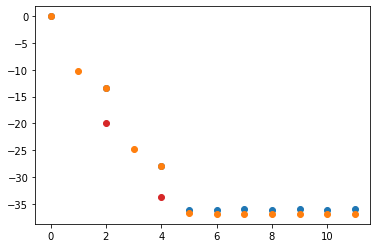

In [64]:
from matplotlib import pyplot as plt

key = 1

plt.scatter(np.arange(0, 12), np.log(corsdict[key]['corA'].real))
plt.scatter(np.arange(0, 12), np.log(corsdict[key]['corB'].real))
plt.scatter(np.arange(0, 12), np.log(corsdict[key]['corA'].imag))
plt.scatter(np.arange(0, 12), np.log(corsdict[key]['corB'].imag))
plt.show()

In [59]:
corsdict[0]['corA'].shape

(12,)

In [48]:
A = np.random.randn(chi * D * D, chi * D * D) + 1j * np.random.randn(chi * D * D, chi * D * D)
Q, R = qr(A)
print(norm(Q @ R - A))

7.226198093493459e-15


In [6]:
def FinishLeft(L0):
    return L0.flatten()


A = np.random.randn(3, 2)
B = FinishLeft(A)
A.shape

(3, 2)

In [9]:
o1, o2 = np.random.randn(2, 3, 5, 7, 11), np.random.randn(11, 13)

(o1 @ o2).shape

(2, 3, 5, 7, 13)